## ASA Coursework 1 - Customer Analytics Study

##### Shiqi BAI (20219140)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import random 
import datetime as dt
import re
import pickle
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation


from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

from collections import Counter 

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline
import os

### 1. Data Preprocessing

In [2]:
data = pd.read_csv('lineitems_sample.csv')
print(data.isnull().any())

customer_number    False
purchase_time      False
product_id         False
category           False
quantity           False
spend              False
dtype: bool


No missing values in the data set

In [3]:
data.duplicated().any()

True

In [4]:
data = data.drop_duplicates()

In [5]:
for i in data.columns:
    data[i] = data[i].astype(str).str.replace('£', '')
    data[i] = data[i].astype(str).str.replace(',', '')

In [6]:
data['spend'] = data['spend'].astype(float)
data['quantity'] = data['quantity'].astype(int)
data['customer_number'] = data['customer_number'].astype(int)
data['purchase_time'] = pd.to_datetime(data.purchase_time)
data=data.sort_values(by=['customer_number','purchase_time'])
data.head()

,customer_number,purchase_time,product_id,category,quantity,spend
62053,14,2007-03-03 15:37:00,40214,DAIRY,1,1.15
62058,14,2007-03-03 15:37:00,604798,DAIRY,1,2.19
62060,14,2007-03-03 15:37:00,652745,DAIRY,1,2.90
62062,14,2007-03-03 15:37:00,16370,CONFECTIONARY,1,0.81
62075,14,2007-03-03 15:37:00,34926,BAKERY,1,0.55


In [7]:
Counter(data['customer_number']>=0)

Counter({True: 1461201})

In [8]:
Counter(data['spend']>=0)

Counter({True: 1460337, False: 864})

In [9]:
data = data[data['spend']>=0]

In [10]:
Counter(data['quantity']>=0)

Counter({True: 1460337})

### 2.Feature Engineering

#### 2.1 Total Feature

In [11]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(data)

customer_number :  3000
purchase_time :  101988
product_id :  20464
category :  20
quantity :  35
spend :  1926


In [12]:
df = data.groupby(by=["customer_number", 'purchase_time']).sum().reset_index()

In [13]:
df.head()

,customer_number,purchase_time,quantity,spend
0,14,2007-03-03 15:37:00,10,16.81
1,14,2007-03-10 15:36:00,18,15.74
2,14,2007-03-21 18:45:00,11,14.75
3,14,2007-03-23 16:29:00,2,2.00
4,14,2007-03-26 16:17:00,4,3.61


In [14]:
custom_aggregation = {}
custom_aggregation["spend"] = ['min','max','mean']
custom_aggregation["quantity"] = "sum"


df_total = df.groupby("customer_number").agg(custom_aggregation)

In [15]:
df_total.columns = ["min_spend", "max_spend", "mean_spend", "quantity"]

In [16]:
df_total.head()

,min_spend,max_spend,mean_spend,quantity
customer_number,,,,
14,1.19,42.84,12.066429,531
45,2.18,35.36,17.749394,655
52,0.75,19.91,3.765763,294
61,2.14,43.09,14.807297,499
63,0.89,21.75,6.111250,281


#### 2.2 Category Spend

In [17]:
category_spend = data.groupby(by=["customer_number", 'purchase_time','category']).sum().reset_index(drop=False).pivot_table(index='customer_number',columns='category',values='spend',aggfunc = "sum").fillna(0)

In [18]:
category_spend.head()

category,BAKERY,CASHPOINT,CONFECTIONARY,DAIRY,DELI,DISCOUNT_BAKERY,DRINKS,FROZEN,FRUIT_VEG,GROCERY_FOOD,GROCERY_HEALTH_PETS,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS
customer_number,,,,,,,,,,,,,,,,,,,,
14,18.09,0.0,23.22,172.58,0.00,1.25,113.45,25.29,11.10,56.05,11.28,0.0,182.37,6.40,0.00,23.36,5.07,5.31,0.0,20.90
45,18.00,0.0,106.54,142.16,2.00,0.00,0.00,7.05,30.21,83.42,24.31,0.0,60.31,17.49,0.00,56.51,0.00,29.65,0.0,8.08
52,2.45,10.0,3.29,5.19,49.07,0.00,0.00,1.78,53.29,1.08,12.11,1.0,9.74,3.12,0.00,2.78,23.20,8.98,0.0,35.10
61,32.75,0.0,46.39,55.29,19.88,0.00,20.65,18.63,70.18,56.18,45.71,6.0,121.38,5.55,2.87,12.12,3.04,14.87,0.0,16.38
63,33.35,0.0,73.07,42.11,32.14,0.00,0.00,14.53,22.01,13.54,25.08,3.0,3.46,2.00,0.00,13.38,0.00,1.67,0.0,14.00


#### 2.3 RFM Principle

In [19]:
df['purchase_time'].min()

Timestamp('2007-03-01 07:06:00')

In [20]:
df['purchase_time'].max()

Timestamp('2007-08-31 21:55:00')

In [21]:
# I'll just fix the date to be one day after the last entry in the databse

NOW = dt.datetime(2007,9,1)

In [22]:
rfmTable = df.loc[:, ['customer_number','purchase_time', 'spend']]

In [23]:
rfmTable.head()

,customer_number,purchase_time,spend
0,14,2007-03-03 15:37:00,16.81
1,14,2007-03-10 15:36:00,15.74
2,14,2007-03-21 18:45:00,14.75
3,14,2007-03-23 16:29:00,2.00
4,14,2007-03-26 16:17:00,3.61


In [24]:
rfmTable["Recency"] = NOW - rfmTable["purchase_time"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [25]:
min(rfmTable['Recency'])

0.0

In [26]:
max(rfmTable['Recency'])

183.0

In [27]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["purchase_time"] = lambda x: len(x)
custom_aggregation["spend"] = "sum"

rfmTable_final = rfmTable.groupby("customer_number").agg(custom_aggregation)

In [28]:
rfmTable_final.head()

Recency        purchase_time   spend
                    min    max      <lambda>     sum
customer_number                                     
14                  1.0  181.0            56  675.72
45                  1.0  183.0            33  585.73
52                  2.0  177.0            59  222.18
61                  3.0  182.0            37  547.87
63                  7.0  182.0            48  293.34

In [29]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [30]:
rfmTable_final.head()

,min_recency,max_recency,frequency,monetary_value
customer_number,,,,
14,1.0,181.0,56,675.72
45,1.0,183.0,33,585.73
52,2.0,177.0,59,222.18
61,3.0,182.0,37,547.87
63,7.0,182.0,48,293.34


In [31]:
rfmTable_final

,min_recency,max_recency,frequency,monetary_value
customer_number,,,,
14,1.0,181.0,56,675.72
45,1.0,183.0,33,585.73
52,2.0,177.0,59,222.18
61,3.0,182.0,37,547.87
63,7.0,182.0,48,293.34
...,...,...,...,...
16295,0.0,182.0,54,679.70
16301,4.0,182.0,42,251.43
16303,11.0,182.0,56,364.32


In [32]:
rfmTable_final.quantile(q=[0.25,0.5,0.75])

,min_recency,max_recency,frequency,monetary_value
0.25,0.0,179.0,32.0,406.7075
0.50,2.0,182.0,53.0,627.5650
0.75,6.0,183.0,86.0,960.5850


In [33]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [34]:
segmented_rfm = rfmTable_final

In [35]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [36]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
customer_number,,,,,,,
14,1.0,181.0,56,675.72,2,2,2
45,1.0,183.0,33,585.73,2,3,3
52,2.0,177.0,59,222.18,2,2,4
61,3.0,182.0,37,547.87,3,3,3
63,7.0,182.0,48,293.34,4,3,4


In [37]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
rfm_score = segmented_rfm[['r_quartile', 'f_quartile', 'm_quartile']]
segmented_rfm = segmented_rfm.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,RFMScore
customer_number,,,,,
14,1.0,181.0,56,675.72,222
45,1.0,183.0,33,585.73,233
52,2.0,177.0,59,222.18,224
61,3.0,182.0,37,547.87,333
63,7.0,182.0,48,293.34,434


In [38]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,RFMScore
customer_number,,,,,
11475,0.0,183.0,198,4456.80,111
8284,0.0,183.0,261,3992.30,111
11106,0.0,183.0,213,3968.49,111
6248,0.0,183.0,188,3940.75,111
10908,0.0,182.0,136,3843.57,111
...,...,...,...,...,...
5903,0.0,182.0,217,980.78,111
3210,0.0,183.0,152,979.21,111
156,0.0,183.0,95,967.75,111


Here we have an example of customers with a score of 111 which means that they are classified as our best customers.

In [39]:
df_rfm = segmented_rfm.drop(columns=['RFMScore'])

In [40]:
df_rfm.head()

,min_recency,max_recency,frequency,monetary_value
customer_number,,,,
14,1.0,181.0,56,675.72
45,1.0,183.0,33,585.73
52,2.0,177.0,59,222.18
61,3.0,182.0,37,547.87
63,7.0,182.0,48,293.34


In [41]:
segmented_rfm = segmented_rfm.reset_index()

In [42]:
segmented_rfm.head()

,customer_number,min_recency,max_recency,frequency,monetary_value,RFMScore
0,14,1.0,181.0,56,675.72,222
1,45,1.0,183.0,33,585.73,233
2,52,2.0,177.0,59,222.18,224
3,61,3.0,182.0,37,547.87,333
4,63,7.0,182.0,48,293.34,434


==> Score's definition

![](https://i.imgur.com/YmItbbm.png?)

#### 2.4 Time Features

In [43]:
df['Month'] = df["purchase_time"].map(lambda x: x.month)

In [44]:
df['Month'].value_counts()

3    35444
5    33339
4    32608
6    31797
7    31651
8    30696
Name: Month, dtype: int64

In [45]:
df['Weekday'] = df["purchase_time"].map(lambda x: x.weekday())
df['Day'] = df["purchase_time"].map(lambda x: x.day)
df['Hour'] = df["purchase_time"].map(lambda x: x.hour)

In [46]:
df = pd.merge(df,segmented_rfm, on='customer_number')

In [47]:
df.head()

,customer_number,purchase_time,quantity,spend,Month,Weekday,Day,Hour,min_recency,max_recency,frequency,monetary_value,RFMScore
0,14,2007-03-03 15:37:00,10,16.81,3,5,3,15,1.0,181.0,56,675.72,222
1,14,2007-03-10 15:36:00,18,15.74,3,5,10,15,1.0,181.0,56,675.72,222
2,14,2007-03-21 18:45:00,11,14.75,3,2,21,18,1.0,181.0,56,675.72,222
3,14,2007-03-23 16:29:00,2,2.00,3,4,23,16,1.0,181.0,56,675.72,222
4,14,2007-03-26 16:17:00,4,3.61,3,0,26,16,1.0,181.0,56,675.72,222


In [48]:
df['count']=1

In [49]:
month = df.groupby(by=["customer_number", 'Month']).sum().reset_index(drop=False).pivot_table(index='customer_number',columns='Month',values='count',aggfunc = "sum").fillna(0)
month.columns = [ 'month-' + str(col) for col in month.columns]

In [50]:
weekday = df.groupby(by=["customer_number", 'Weekday']).sum().reset_index(drop=False).pivot_table(index='customer_number',columns='Weekday',values='count',aggfunc = "sum").fillna(0)
weekday.columns = [ 'weekday-' + str(col) for col in weekday.columns]

In [51]:
day = df.groupby(by=["customer_number", 'Day']).sum().reset_index(drop=False).pivot_table(index='customer_number',columns='Day',values='count',aggfunc = "sum").fillna(0)
day.columns = [ 'day-' + str(col) for col in day.columns]

In [52]:
hour = df.groupby(by=["customer_number", 'Hour']).sum().reset_index(drop=False).pivot_table(index='customer_number',columns='Hour',values='count',aggfunc = "sum").fillna(0)
hour.columns = [ 'hour-' + str(col) for col in hour.columns]

In [53]:
time = pd.concat([month,weekday,day,hour],axis=1)

In [54]:
time.head()

,month-3,month-4,month-5,month-6,month-7,month-8,weekday-0,weekday-1,weekday-2,weekday-3,...,hour-13,hour-14,hour-15,hour-16,hour-17,hour-18,hour-19,hour-20,hour-21,hour-22
customer_number,,,,,,,,,,,,,,,,,,,,,
14,7.0,10.0,9.0,13.0,8.0,9.0,11.0,6.0,8.0,5.0,...,3.0,4.0,5.0,29.0,5.0,3.0,1.0,0.0,0.0,0.0
45,6.0,6.0,6.0,6.0,5.0,4.0,3.0,4.0,0.0,25.0,...,13.0,8.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0
52,10.0,10.0,11.0,8.0,11.0,9.0,9.0,11.0,13.0,14.0,...,1.0,0.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0
61,3.0,4.0,6.0,8.0,8.0,8.0,11.0,3.0,9.0,5.0,...,2.0,4.0,8.0,14.0,3.0,1.0,0.0,0.0,0.0,0.0
63,13.0,4.0,6.0,6.0,11.0,8.0,7.0,5.0,10.0,8.0,...,14.0,5.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0


In [55]:
df[df['customer_number']==14]['Month'].value_counts().sort_index( )

3     7
4    10
5     9
6    13
7     8
8     9
Name: Month, dtype: int64

### 3.Customer Base Analysis

#### 3.1 total_spend

(array([162., 995., 822., 449., 208., 126.,  78.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35]),
 <a list of 7 Patch objects>)

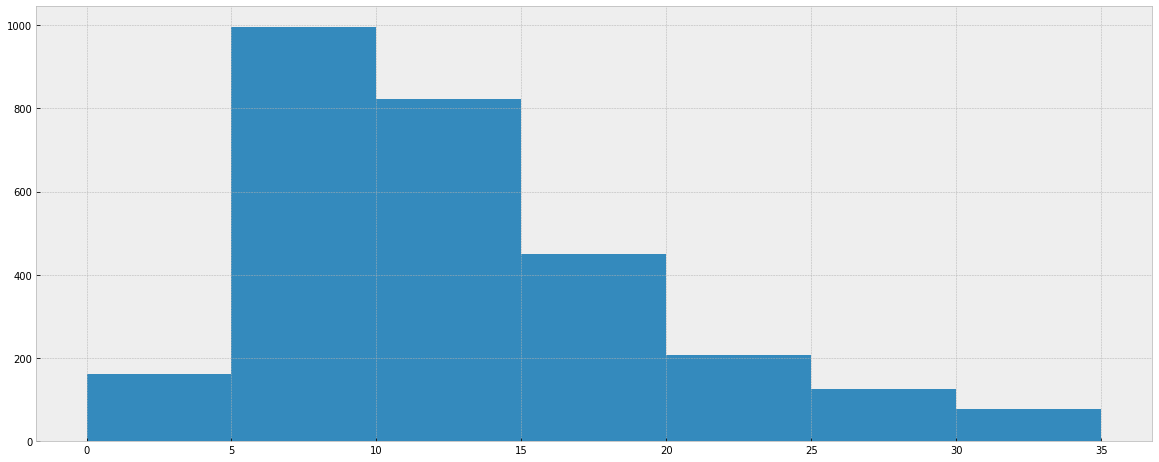

In [56]:
plt.figure(figsize = (20,8))
plt.hist(df_total['mean_spend'], bins=np.arange(0,40,5))

(array([1778.,  897.,  209.,   70.]),
 array([ 0, 10, 20, 30, 40]),
 <a list of 4 Patch objects>)

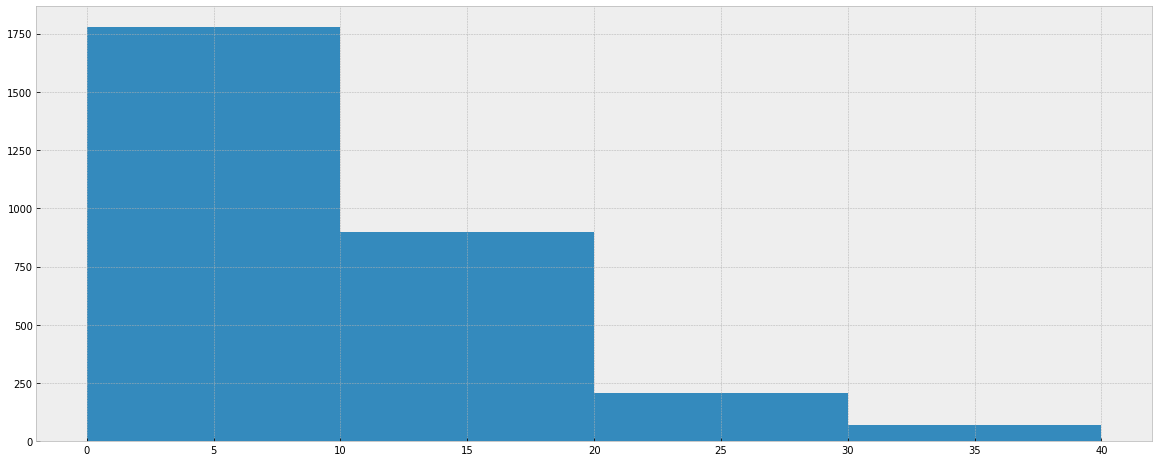

In [57]:
plt.figure(figsize = (20,8))
plt.hist(df.groupby(by=["customer_number"]).mean()['quantity'], bins=np.arange(0,50,10))

#### 3.2 visits_time

In [58]:
Counter(data.groupby(by=["customer_number"]).nunique()['purchase_time']>100)

Counter({False: 2456, True: 544})

(array([304., 747., 658., 397., 336., 209., 118.,  87.,  60.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180]),
 <a list of 9 Patch objects>)

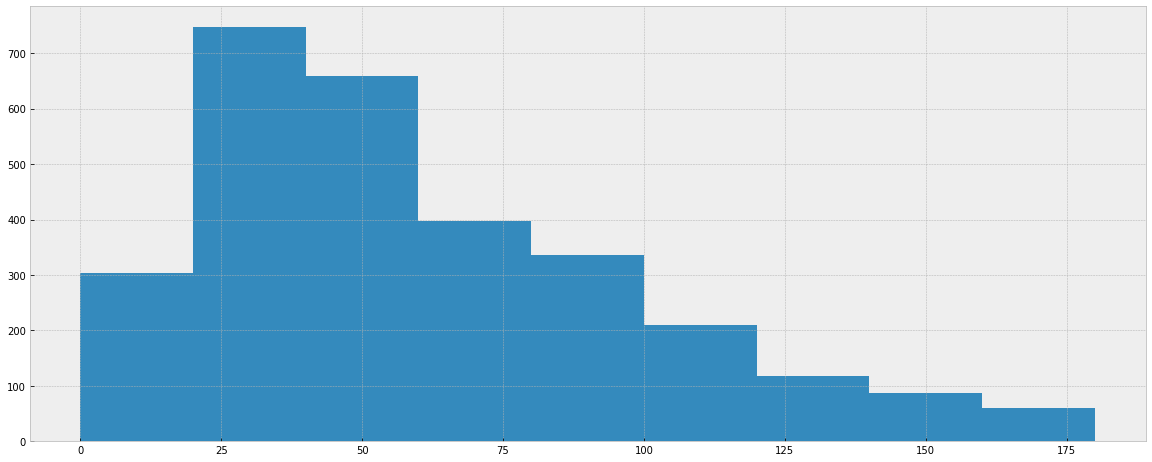

In [59]:
plt.figure(figsize = (20,8))
plt.hist(data.groupby(by=["customer_number"]).nunique()['purchase_time'], bins=np.arange(0,200,20))

Most customers visits less than 100 times

#### 3.3 category_spend

In [60]:
category_spend.head()

category,BAKERY,CASHPOINT,CONFECTIONARY,DAIRY,DELI,DISCOUNT_BAKERY,DRINKS,FROZEN,FRUIT_VEG,GROCERY_FOOD,GROCERY_HEALTH_PETS,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS
customer_number,,,,,,,,,,,,,,,,,,,,
14,18.09,0.0,23.22,172.58,0.00,1.25,113.45,25.29,11.10,56.05,11.28,0.0,182.37,6.40,0.00,23.36,5.07,5.31,0.0,20.90
45,18.00,0.0,106.54,142.16,2.00,0.00,0.00,7.05,30.21,83.42,24.31,0.0,60.31,17.49,0.00,56.51,0.00,29.65,0.0,8.08
52,2.45,10.0,3.29,5.19,49.07,0.00,0.00,1.78,53.29,1.08,12.11,1.0,9.74,3.12,0.00,2.78,23.20,8.98,0.0,35.10
61,32.75,0.0,46.39,55.29,19.88,0.00,20.65,18.63,70.18,56.18,45.71,6.0,121.38,5.55,2.87,12.12,3.04,14.87,0.0,16.38
63,33.35,0.0,73.07,42.11,32.14,0.00,0.00,14.53,22.01,13.54,25.08,3.0,3.46,2.00,0.00,13.38,0.00,1.67,0.0,14.00


In [61]:
category_spend.sum().sort_values()

category
DISCOUNT_BAKERY           5442.50
PRACTICAL_ITEMS           6048.66
SEASONAL_GIFTING         18378.00
WORLD_FOODS              25661.79
DELI                     41209.71
LOTTERY                  47528.26
NEWSPAPERS_MAGAZINES     49951.26
SOFT_DRINKS              69922.49
FROZEN                  106395.60
PREPARED_MEALS          106438.41
BAKERY                  114624.69
CASHPOINT               135976.75
MEAT                    164219.00
CONFECTIONARY           172072.74
GROCERY_FOOD            180018.66
GROCERY_HEALTH_PETS     182730.88
DRINKS                  186718.57
FRUIT_VEG               208351.91
DAIRY                   213879.97
TOBACCO                 277573.11
dtype: float64

In total, customers spend most on tobacco and least on discount_bakery and practical_items.

In [62]:
category_quantity = data.groupby(by=["customer_number", 'purchase_time','category']).sum().reset_index(drop=False).pivot_table(index='customer_number',columns='category',values='quantity',aggfunc = "sum").fillna(0)

In [63]:
category_quantity.head()

category,BAKERY,CASHPOINT,CONFECTIONARY,DAIRY,DELI,DISCOUNT_BAKERY,DRINKS,FROZEN,FRUIT_VEG,GROCERY_FOOD,GROCERY_HEALTH_PETS,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS
customer_number,,,,,,,,,,,,,,,,,,,,
14,29.0,0.0,28.0,133.0,0.0,1.0,69.0,14.0,18.0,57.0,44.0,0.0,69.0,2.0,0.0,10.0,4.0,17.0,0.0,36.0
45,23.0,0.0,126.0,183.0,1.0,0.0,0.0,5.0,27.0,108.0,25.0,0.0,33.0,41.0,0.0,35.0,0.0,38.0,0.0,10.0
52,5.0,1.0,10.0,9.0,30.0,0.0,0.0,1.0,54.0,1.0,9.0,1.0,6.0,3.0,0.0,2.0,7.0,18.0,0.0,137.0
61,49.0,0.0,81.0,52.0,16.0,0.0,4.0,9.0,59.0,72.0,27.0,1.0,64.0,10.0,3.0,8.0,3.0,19.0,0.0,22.0
63,40.0,0.0,71.0,42.0,17.0,0.0,0.0,11.0,21.0,15.0,25.0,3.0,2.0,3.0,0.0,12.0,0.0,3.0,0.0,16.0


In [64]:
category_quantity.sum().sort_values()

category
PRACTICAL_ITEMS           3103.0
DISCOUNT_BAKERY           5170.0
SEASONAL_GIFTING          8107.0
CASHPOINT                11855.0
LOTTERY                  18574.0
DELI                     31798.0
WORLD_FOODS              40936.0
DRINKS                   48164.0
TOBACCO                  63960.0
FROZEN                   69079.0
MEAT                     71778.0
NEWSPAPERS_MAGAZINES     76932.0
PREPARED_MEALS           78106.0
SOFT_DRINKS              82084.0
BAKERY                  133717.0
GROCERY_HEALTH_PETS     150829.0
GROCERY_FOOD            201772.0
CONFECTIONARY           215836.0
FRUIT_VEG               215941.0
DAIRY                   224275.0
dtype: float64

In terms of number of purchases, customers bought the most dairy and less tobaccos.This may be because the unit price of tobacco is higher.

#### 3.4 time

In [65]:
df.head()

,customer_number,purchase_time,quantity,spend,Month,Weekday,Day,Hour,min_recency,max_recency,frequency,monetary_value,RFMScore,count
0,14,2007-03-03 15:37:00,10,16.81,3,5,3,15,1.0,181.0,56,675.72,222,1
1,14,2007-03-10 15:36:00,18,15.74,3,5,10,15,1.0,181.0,56,675.72,222,1
2,14,2007-03-21 18:45:00,11,14.75,3,2,21,18,1.0,181.0,56,675.72,222,1
3,14,2007-03-23 16:29:00,2,2.00,3,4,23,16,1.0,181.0,56,675.72,222,1
4,14,2007-03-26 16:17:00,4,3.61,3,0,26,16,1.0,181.0,56,675.72,222,1


In [66]:
time.sum()

month-3    35444.0
month-4    32608.0
month-5    33339.0
month-6    31797.0
month-7    31651.0
            ...   
hour-18     9419.0
hour-19     7018.0
hour-20     4282.0
hour-21     2451.0
hour-22       85.0
Length: 62, dtype: float64

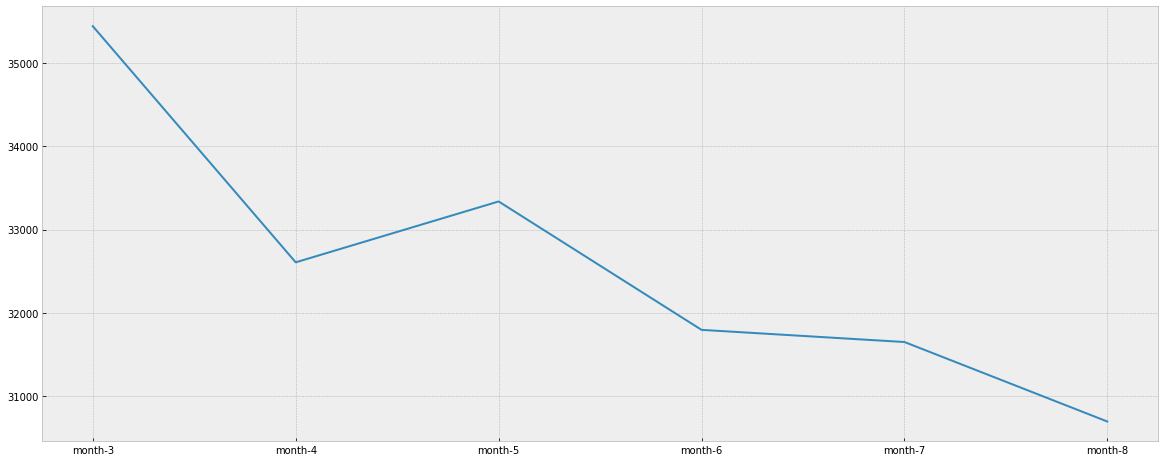

In [67]:
plt.figure(figsize = (20,8))
plt.plot(time.sum()[:6])

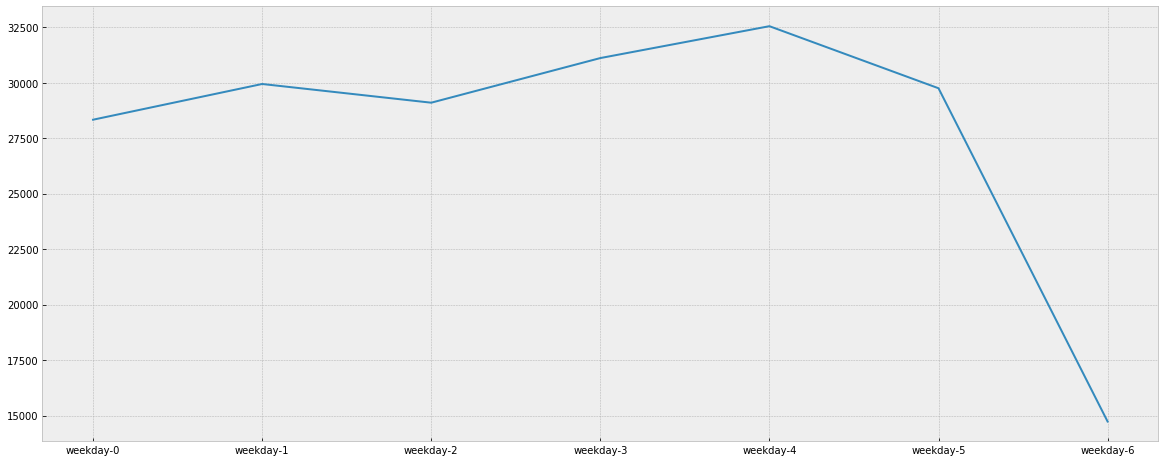

In [68]:
plt.figure(figsize = (20,8))
plt.plot(time.sum()[6:13])

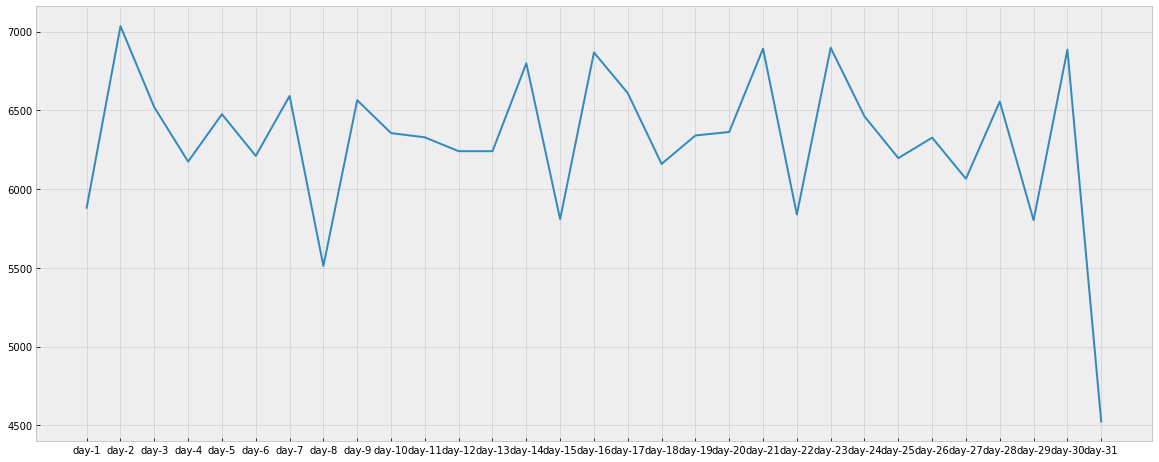

In [69]:
plt.figure(figsize = (20,8))
plt.plot(time.sum()[13:44])

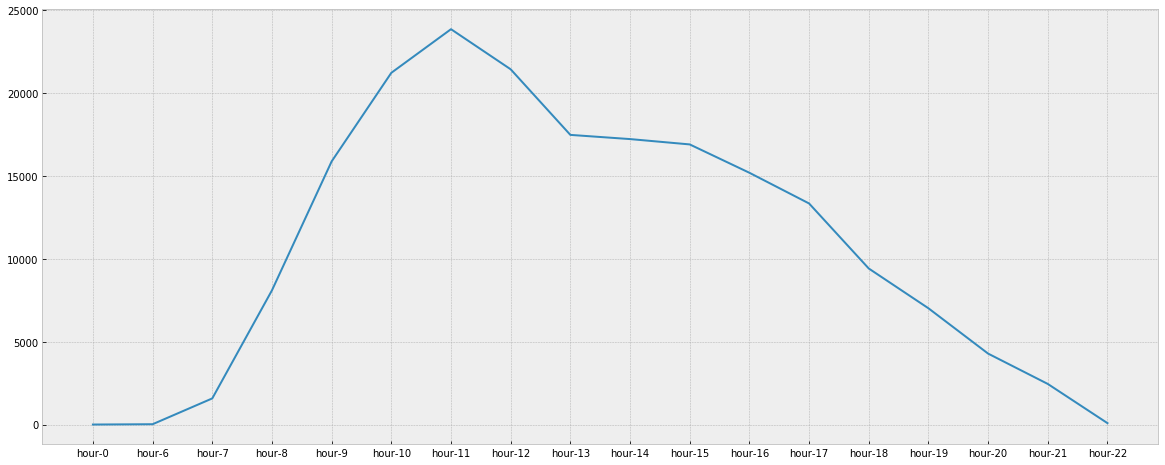

In [70]:
plt.figure(figsize = (20,8))
plt.plot(time.sum()[44:70])

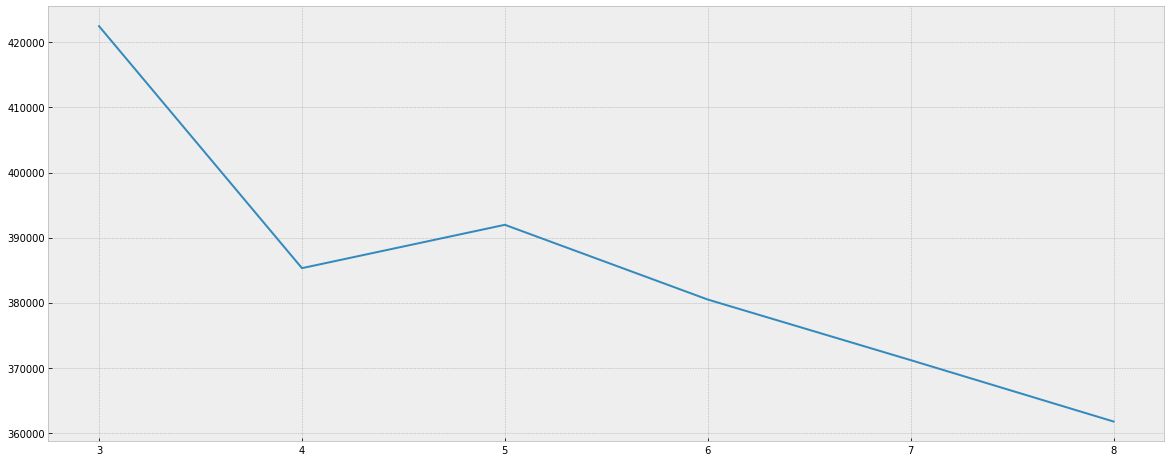

In [71]:
plt.figure(figsize = (20,8))
plt.plot(df.groupby(['Month']).sum()['spend'])

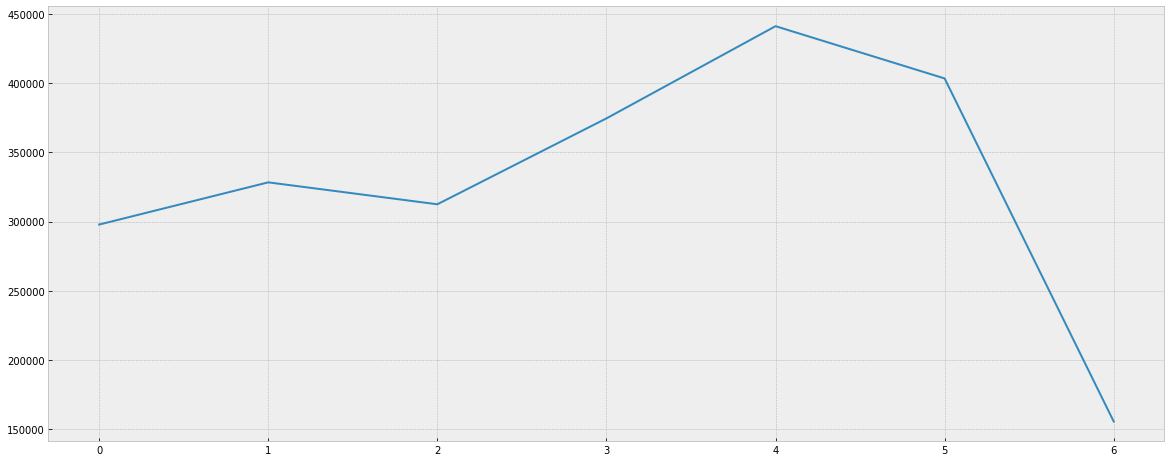

In [72]:
plt.figure(figsize = (20,8))
plt.plot(df.groupby(['Weekday']).sum()['spend'])

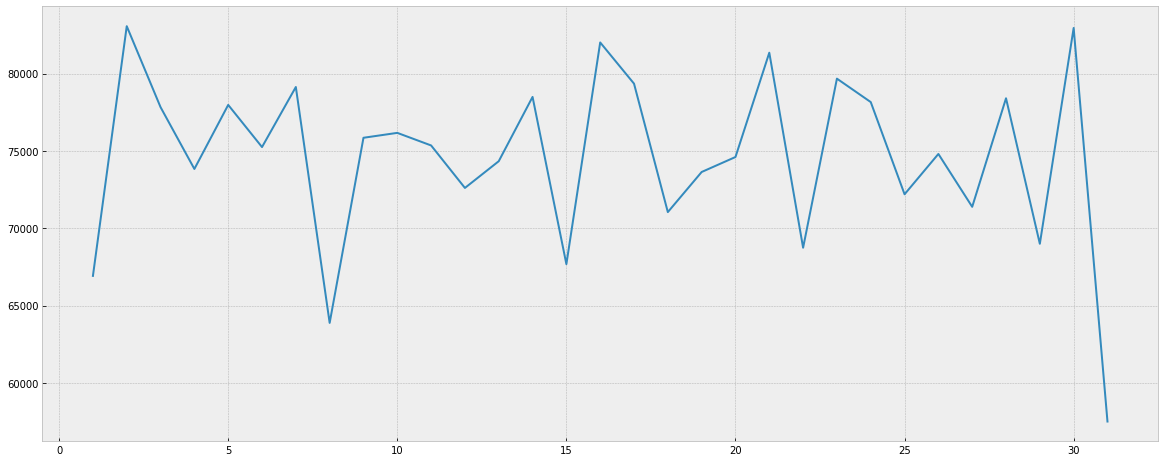

In [73]:
plt.figure(figsize = (20,8))
plt.plot(df.groupby(['Day']).sum()['spend'])

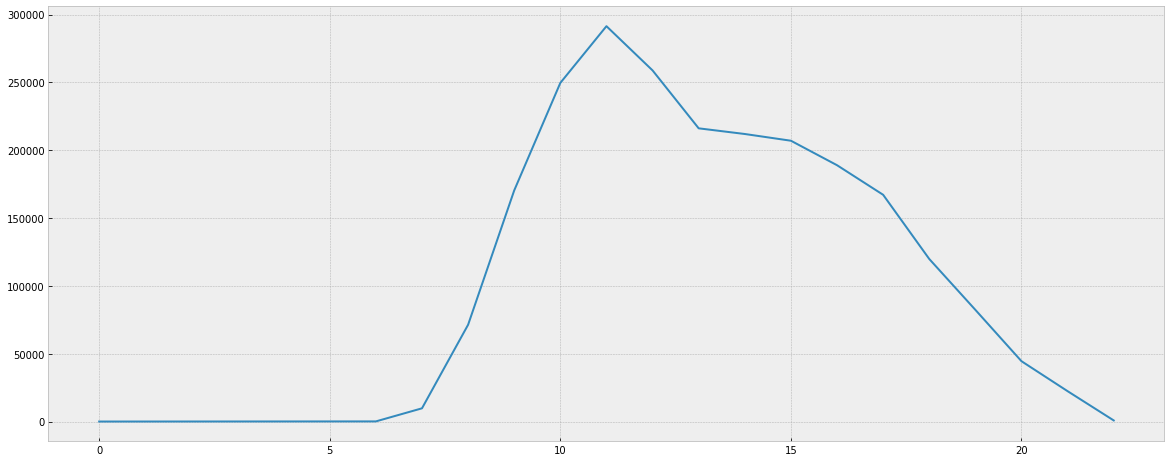

In [74]:
plt.figure(figsize = (20,8))
plt.plot(df.groupby(['Hour']).sum()['spend'])

In [75]:
df['Month'].value_counts()

3    35444
5    33339
4    32608
6    31797
7    31651
8    30696
Name: Month, dtype: int64

#### 3.5 RFM Principle

(array([1474.,  550.,  162.,  243.,   87.,   82.,   42.,   43.,   39.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18]),
 <a list of 9 Patch objects>)

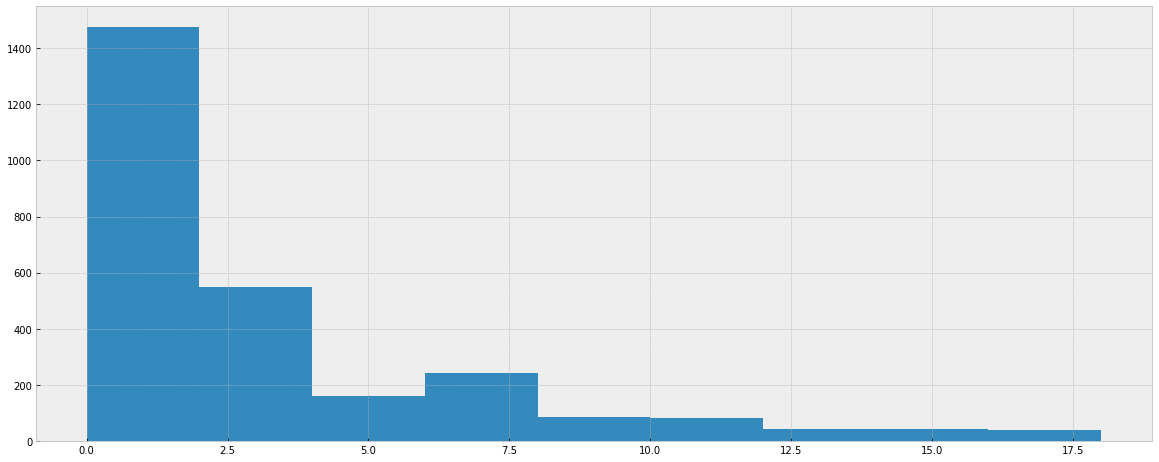

In [76]:
plt.figure(figsize = (20,8))
plt.hist(segmented_rfm['min_recency'], bins=np.arange(0,20,2))

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 2.]),
 array([100, 103, 106, 109, 112, 115, 118, 121, 124, 127, 130, 133, 136,
        139, 142, 145, 148]),
 <a list of 16 Patch objects>)

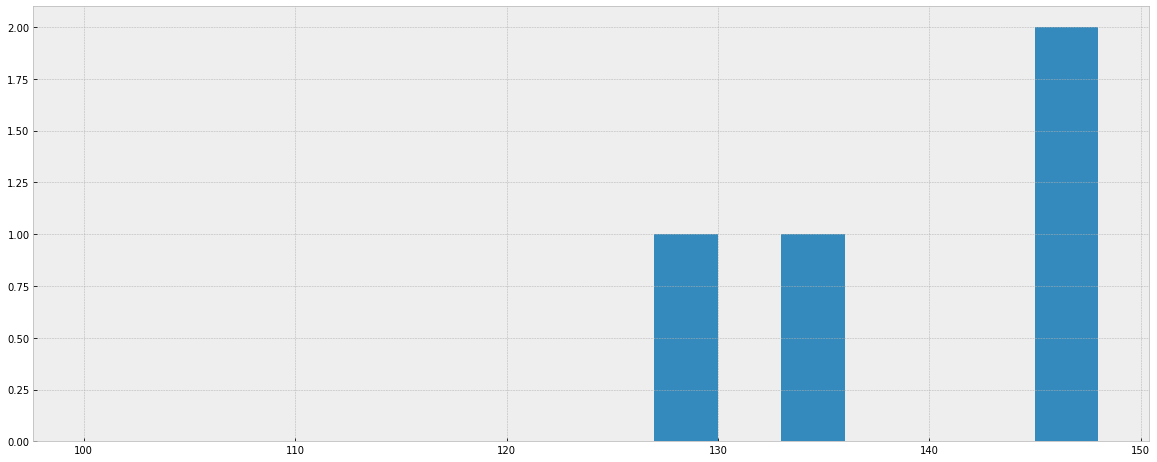

In [77]:
plt.figure(figsize = (20,8))
plt.hist(segmented_rfm['max_recency'], bins=np.arange(100,150,3))

(array([1385., 1057.,  376.,  130.,   33.,   11.]),
 array([  0,  50, 100, 150, 200, 250, 300]),
 <a list of 6 Patch objects>)

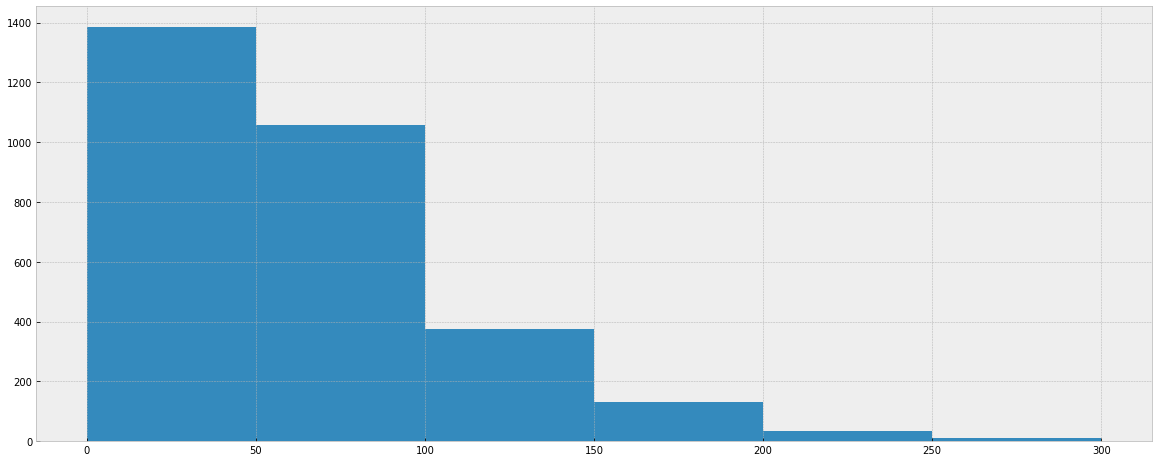

In [78]:
plt.figure(figsize = (20,8))
plt.hist(segmented_rfm['frequency'], bins=np.arange(0,350,50))

(array([2309.,  577.,   96.,   14.]),
 array([   0, 1000, 2000, 3000, 4000]),
 <a list of 4 Patch objects>)

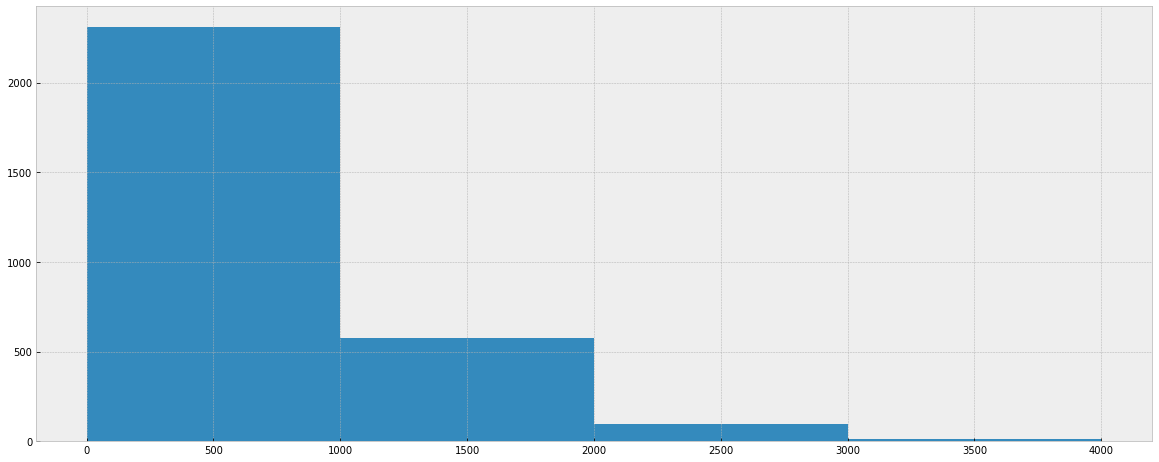

In [79]:
plt.figure(figsize = (20,8))
plt.hist(segmented_rfm['monetary_value'], bins=np.arange(0,5000,1000))

### 4.Clustering customers

In [80]:
df_final = pd.concat([df_total, df_rfm, time, category_spend], axis=1)

In [81]:
df_final.head()

,min_spend,max_spend,mean_spend,quantity,min_recency,max_recency,frequency,monetary_value,month-3,month-4,...,GROCERY_HEALTH_PETS,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS
customer_number,,,,,,,,,,,,,,,,,,,,,
14,1.19,42.84,12.066429,531,1.0,181.0,56,675.72,7.0,10.0,...,11.28,0.0,182.37,6.40,0.00,23.36,5.07,5.31,0.0,20.90
45,2.18,35.36,17.749394,655,1.0,183.0,33,585.73,6.0,6.0,...,24.31,0.0,60.31,17.49,0.00,56.51,0.00,29.65,0.0,8.08
52,0.75,19.91,3.765763,294,2.0,177.0,59,222.18,10.0,10.0,...,12.11,1.0,9.74,3.12,0.00,2.78,23.20,8.98,0.0,35.10
61,2.14,43.09,14.807297,499,3.0,182.0,37,547.87,3.0,4.0,...,45.71,6.0,121.38,5.55,2.87,12.12,3.04,14.87,0.0,16.38
63,0.89,21.75,6.111250,281,7.0,182.0,48,293.34,13.0,4.0,...,25.08,3.0,3.46,2.00,0.00,13.38,0.00,1.67,0.0,14.00


In [82]:
X = df_final.as_matrix()
scaler = StandardScaler()
X_final_std_scale = scaler.fit_transform(X)

In [83]:
x = list(range(5, 8))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 5
The average silhouette_score is : 0.10860471404438586 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.05671044799915751 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.05366853350600879 with Std Scaling


We want to have 5-7 clusters.5 clusters have the highest silhouette scores.So we choose it.

In [84]:
kmeans = KMeans(init='k-means++', n_clusters = 5, n_init=30, random_state=2)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

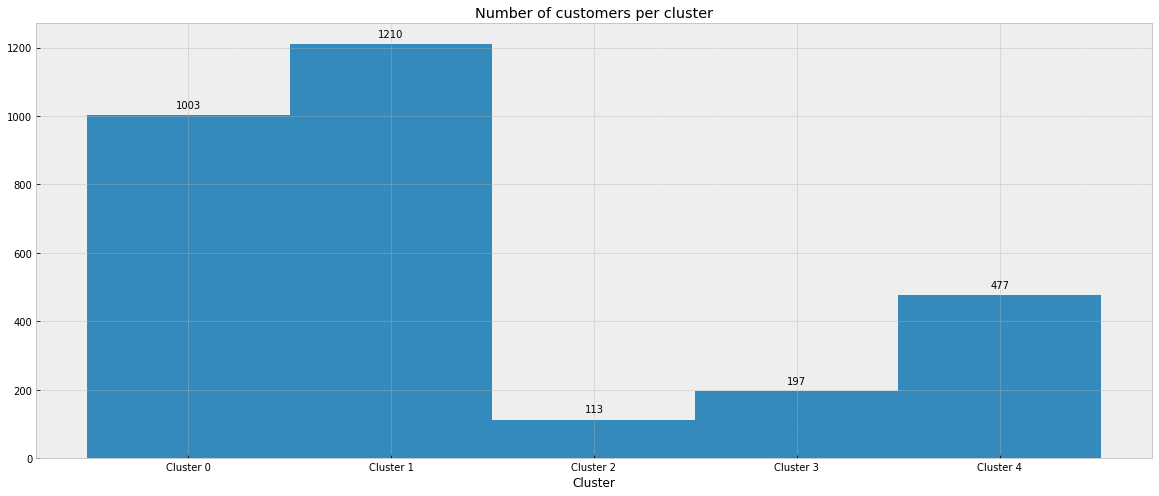

In [85]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=5)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(5)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [86]:
Counter(clusters)

Counter({0: 1003, 1: 1210, 3: 197, 4: 477, 2: 113})

In [87]:
df_final["cluster"] = clusters

Output results file

In [88]:
final_dataset = df_final.reset_index()

In [89]:
final_dataset.to_csv(" results file.csv",index=False)

In [90]:
df_final.head()

,min_spend,max_spend,mean_spend,quantity,min_recency,max_recency,frequency,monetary_value,month-3,month-4,...,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS,cluster
customer_number,,,,,,,,,,,,,,,,,,,,,
14,1.19,42.84,12.066429,531,1.0,181.0,56,675.72,7.0,10.0,...,0.0,182.37,6.40,0.00,23.36,5.07,5.31,0.0,20.90,0
45,2.18,35.36,17.749394,655,1.0,183.0,33,585.73,6.0,6.0,...,0.0,60.31,17.49,0.00,56.51,0.00,29.65,0.0,8.08,1
52,0.75,19.91,3.765763,294,2.0,177.0,59,222.18,10.0,10.0,...,1.0,9.74,3.12,0.00,2.78,23.20,8.98,0.0,35.10,0
61,2.14,43.09,14.807297,499,3.0,182.0,37,547.87,3.0,4.0,...,6.0,121.38,5.55,2.87,12.12,3.04,14.87,0.0,16.38,1
63,0.89,21.75,6.111250,281,7.0,182.0,48,293.34,13.0,4.0,...,3.0,3.46,2.00,0.00,13.38,0.00,1.67,0.0,14.00,0


### 5. Interpreting the clusters

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

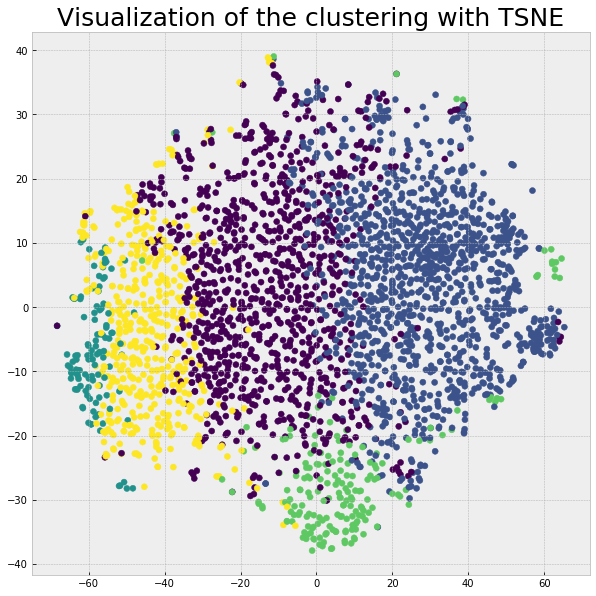

In [91]:
tsne = TSNE(n_components=2, random_state=1)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

Graphically the clusters are distinctive enough.
Let's take a closer look at the specific clusters.

In [92]:
temp_final_df = df_final.reset_index()

In [93]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['customer_number'])
data0 = data[data['customer_number'].isin(cust0)]
cluster0 = df[df['customer_number'].isin(cust0)]

cust1 = list(temp_final_df[temp_final_df['cluster']==1]['customer_number'])
data1 = data[data['customer_number'].isin(cust1)]
cluster1 = df[df['customer_number'].isin(cust1)]

cust2 = list(temp_final_df[temp_final_df['cluster']==2]['customer_number'])
data2 = data[data['customer_number'].isin(cust2)]
cluster2 = df[df['customer_number'].isin(cust2)]

cust3 = list(temp_final_df[temp_final_df['cluster']==3]['customer_number'])
data3 = data[data['customer_number'].isin(cust3)]
cluster3 = df[df['customer_number'].isin(cust3)]

cust4 = list(temp_final_df[temp_final_df['cluster']==4]['customer_number'])
data4 = data[data['customer_number'].isin(cust4)]
cluster4 = df[df['customer_number'].isin(cust4)]

In [94]:
print(cluster0['spend'].sum())
print(cluster1['spend'].sum())
print(cluster2['spend'].sum())
print(cluster3['spend'].sum())
print(cluster4['spend'].sum())

698042.5
542389.5499999999
207485.46999999997
338521.73
526703.7100000001


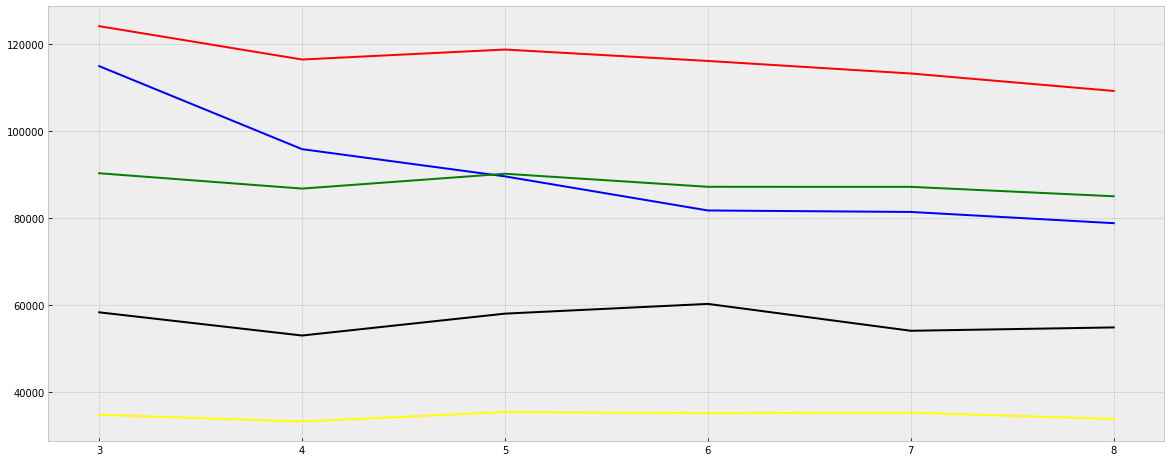

In [95]:
plt.figure(figsize = (20,8))
plt.plot(cluster0.groupby(['Month']).sum()['spend'], c='red')
plt.plot(cluster1.groupby(['Month']).sum()['spend'], c='blue')
plt.plot(cluster2.groupby(['Month']).sum()['spend'], c='yellow')
plt.plot(cluster3.groupby(['Month']).sum()['spend'], c='black')
plt.plot(cluster4.groupby(['Month']).sum()['spend'], c='green')

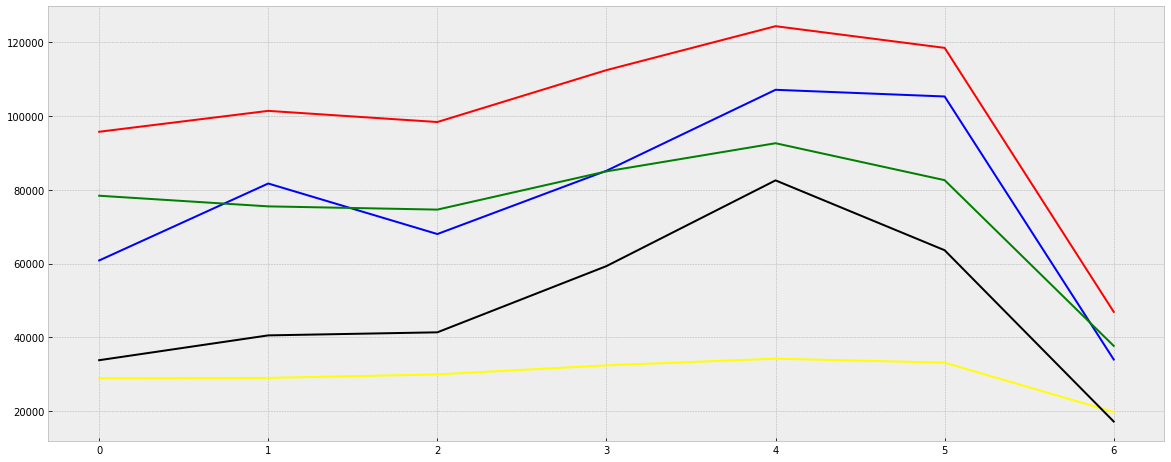

In [96]:
plt.figure(figsize = (20,8))
plt.plot(cluster0.groupby(['Weekday']).sum()['spend'], c='red')
plt.plot(cluster1.groupby(['Weekday']).sum()['spend'], c='blue')
plt.plot(cluster2.groupby(['Weekday']).sum()['spend'], c='yellow')
plt.plot(cluster3.groupby(['Weekday']).sum()['spend'], c='black')
plt.plot(cluster4.groupby(['Weekday']).sum()['spend'], c='green')

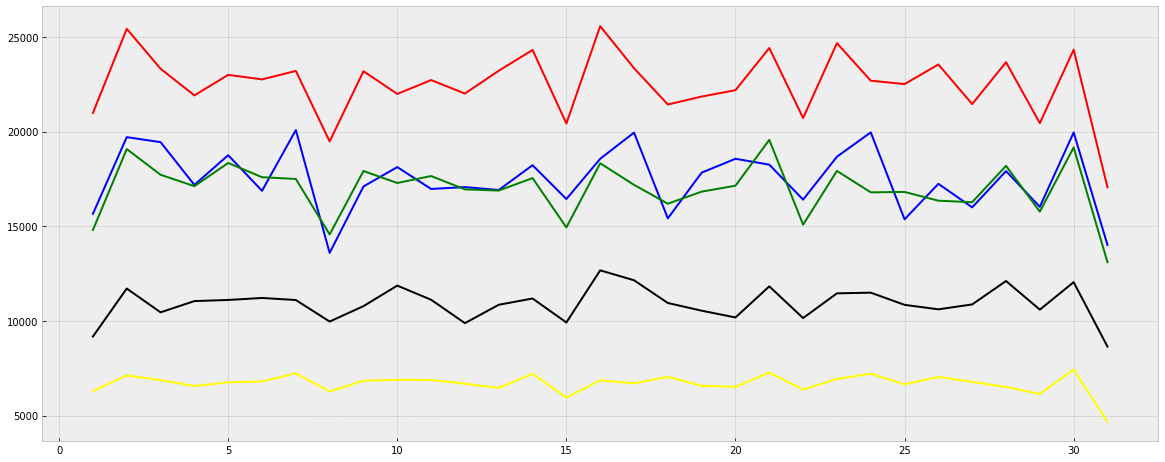

In [97]:
plt.figure(figsize = (20,8))
plt.plot(cluster0.groupby(['Day']).sum()['spend'], c='red')
plt.plot(cluster1.groupby(['Day']).sum()['spend'], c='blue')
plt.plot(cluster2.groupby(['Day']).sum()['spend'], c='yellow')
plt.plot(cluster3.groupby(['Day']).sum()['spend'], c='black')
plt.plot(cluster4.groupby(['Day']).sum()['spend'], c='green')

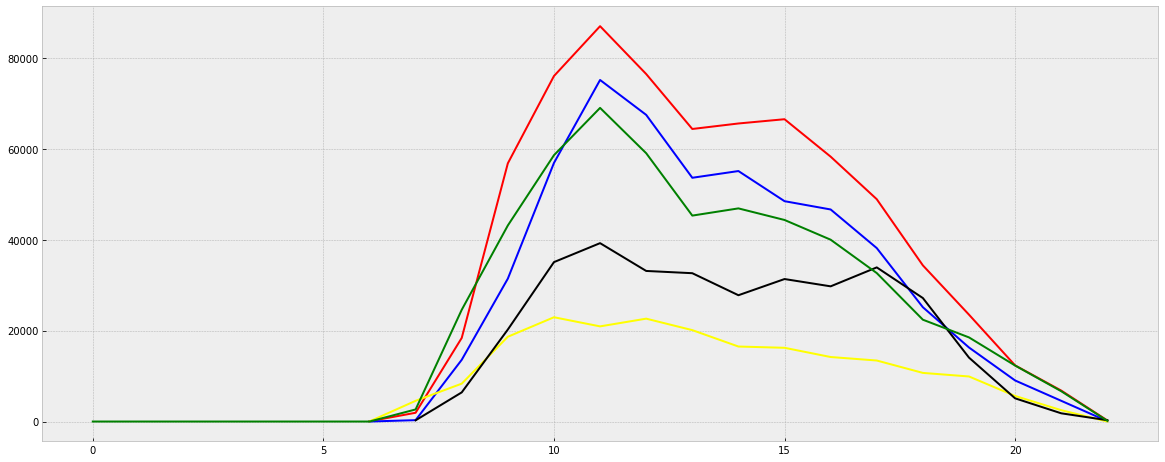

In [98]:
plt.figure(figsize = (20,8))
plt.plot(cluster0.groupby(['Hour']).sum()['spend'], c='red')
plt.plot(cluster1.groupby(['Hour']).sum()['spend'], c='blue')
plt.plot(cluster2.groupby(['Hour']).sum()['spend'], c='yellow')
plt.plot(cluster3.groupby(['Hour']).sum()['spend'], c='black')
plt.plot(cluster4.groupby(['Hour']).sum()['spend'], c='green')

#### 5.1 Cluster 0

In [99]:
df_final[df_final['cluster']==0]

,min_spend,max_spend,mean_spend,quantity,min_recency,max_recency,frequency,monetary_value,month-3,month-4,...,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS,cluster
customer_number,,,,,,,,,,,,,,,,,,,,,
14,1.19,42.84,12.066429,531,1.0,181.0,56,675.72,7.0,10.0,...,0.0,182.37,6.40,0.00,23.36,5.07,5.31,0.00,20.90,0
52,0.75,19.91,3.765763,294,2.0,177.0,59,222.18,10.0,10.0,...,1.0,9.74,3.12,0.00,2.78,23.20,8.98,0.00,35.10,0
63,0.89,21.75,6.111250,281,7.0,182.0,48,293.34,13.0,4.0,...,3.0,3.46,2.00,0.00,13.38,0.00,1.67,0.00,14.00,0
83,0.73,22.10,9.784528,434,6.0,179.0,53,518.58,11.0,10.0,...,0.0,46.26,12.59,0.00,47.74,13.85,8.11,0.00,2.74,0
85,0.65,31.89,8.966269,324,1.0,183.0,67,600.74,13.0,9.0,...,8.0,5.28,0.35,0.00,33.83,0.30,6.61,0.00,11.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16254,2.22,49.36,8.848846,372,1.0,177.0,52,460.14,12.0,7.0,...,5.0,0.00,6.12,0.84,16.37,0.00,13.24,0.00,2.66,0
16281,1.26,22.64,11.328136,685,0.0,182.0,59,668.36,8.0,11.0,...,0.0,0.00,41.05,4.20,79.33,1.15,2.93,0.00,11.36,0
16287,0.57,45.74,10.784789,583,7.0,180.0,71,765.72,10.0,17.0,...,81.0,0.00,28.55,0.00,23.90,0.00,29.44,10.54,0.00,0


In [100]:
df_final[df_final['cluster']==0]

,min_spend,max_spend,mean_spend,quantity,min_recency,max_recency,frequency,monetary_value,month-3,month-4,...,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS,cluster
customer_number,,,,,,,,,,,,,,,,,,,,,
14,1.19,42.84,12.066429,531,1.0,181.0,56,675.72,7.0,10.0,...,0.0,182.37,6.40,0.00,23.36,5.07,5.31,0.00,20.90,0
52,0.75,19.91,3.765763,294,2.0,177.0,59,222.18,10.0,10.0,...,1.0,9.74,3.12,0.00,2.78,23.20,8.98,0.00,35.10,0
63,0.89,21.75,6.111250,281,7.0,182.0,48,293.34,13.0,4.0,...,3.0,3.46,2.00,0.00,13.38,0.00,1.67,0.00,14.00,0
83,0.73,22.10,9.784528,434,6.0,179.0,53,518.58,11.0,10.0,...,0.0,46.26,12.59,0.00,47.74,13.85,8.11,0.00,2.74,0
85,0.65,31.89,8.966269,324,1.0,183.0,67,600.74,13.0,9.0,...,8.0,5.28,0.35,0.00,33.83,0.30,6.61,0.00,11.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16254,2.22,49.36,8.848846,372,1.0,177.0,52,460.14,12.0,7.0,...,5.0,0.00,6.12,0.84,16.37,0.00,13.24,0.00,2.66,0
16281,1.26,22.64,11.328136,685,0.0,182.0,59,668.36,8.0,11.0,...,0.0,0.00,41.05,4.20,79.33,1.15,2.93,0.00,11.36,0
16287,0.57,45.74,10.784789,583,7.0,180.0,71,765.72,10.0,17.0,...,81.0,0.00,28.55,0.00,23.90,0.00,29.44,10.54,0.00,0


In [101]:
cluster0.head()

,customer_number,purchase_time,quantity,spend,Month,Weekday,Day,Hour,min_recency,max_recency,frequency,monetary_value,RFMScore,count
0,14,2007-03-03 15:37:00,10,16.81,3,5,3,15,1.0,181.0,56,675.72,222,1
1,14,2007-03-10 15:36:00,18,15.74,3,5,10,15,1.0,181.0,56,675.72,222,1
2,14,2007-03-21 18:45:00,11,14.75,3,2,21,18,1.0,181.0,56,675.72,222,1
3,14,2007-03-23 16:29:00,2,2.00,3,4,23,16,1.0,181.0,56,675.72,222,1
4,14,2007-03-26 16:17:00,4,3.61,3,0,26,16,1.0,181.0,56,675.72,222,1


In [102]:
custom_aggregation = {}
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]
cluster0_RFMScore = cluster0.groupby("customer_number").agg(custom_aggregation)

In [103]:
cluster0['Month'].value_counts()

3    12138
5    11553
4    11274
6    11075
7    10941
8    10480
Name: Month, dtype: int64

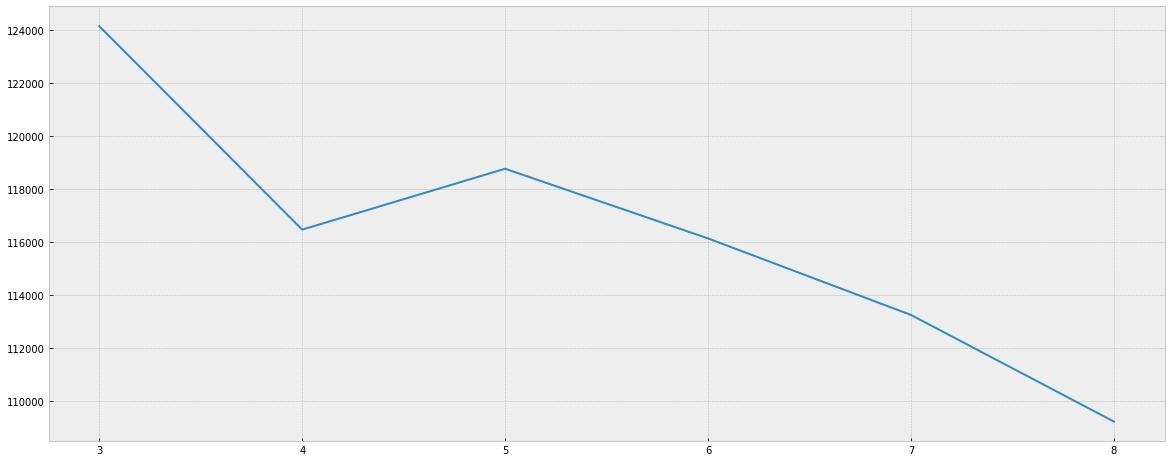

In [104]:
plt.figure(figsize = (20,8))
plt.plot(cluster0.groupby(['Month']).sum()['spend'])

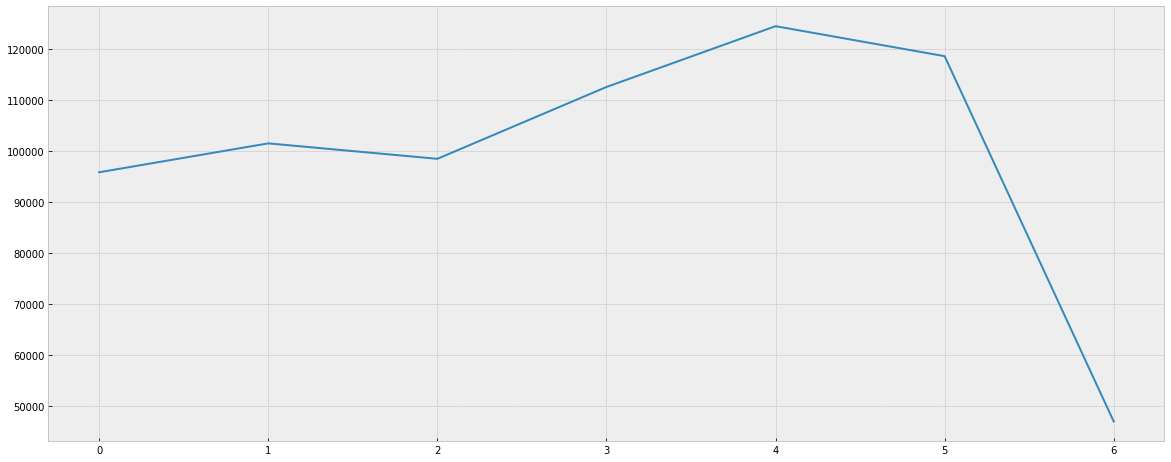

In [105]:
plt.figure(figsize = (20,8))
plt.plot(cluster0.groupby(['Weekday']).sum()['spend'])

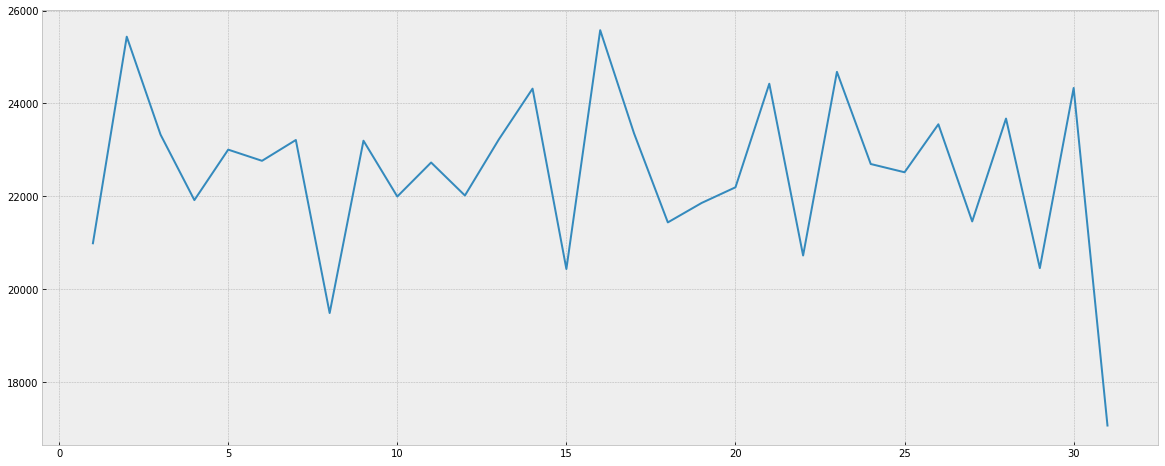

In [106]:
plt.figure(figsize = (20,8))
plt.plot(cluster0.groupby(['Day']).sum()['spend'])

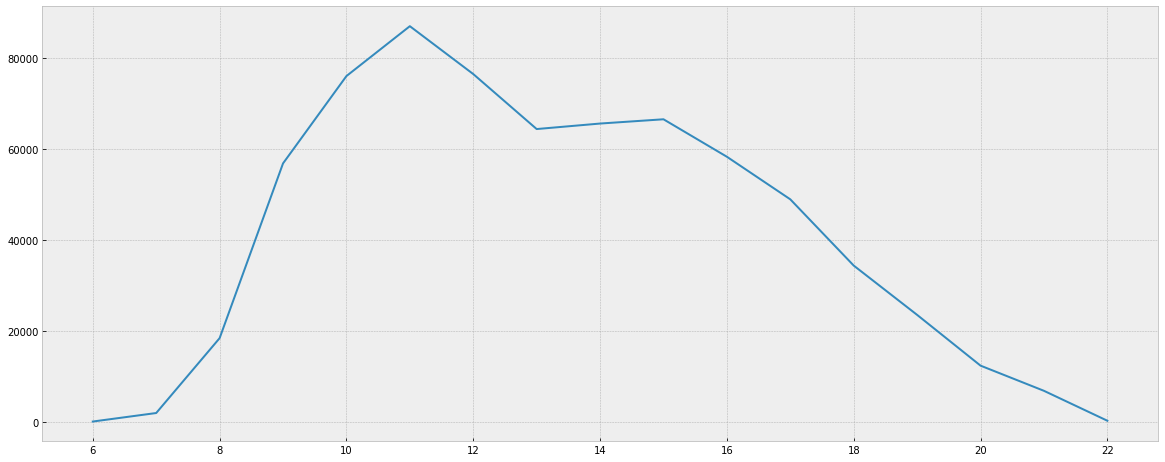

In [107]:
plt.figure(figsize = (20,8))
plt.plot(cluster0.groupby(['Hour']).sum()['spend'])

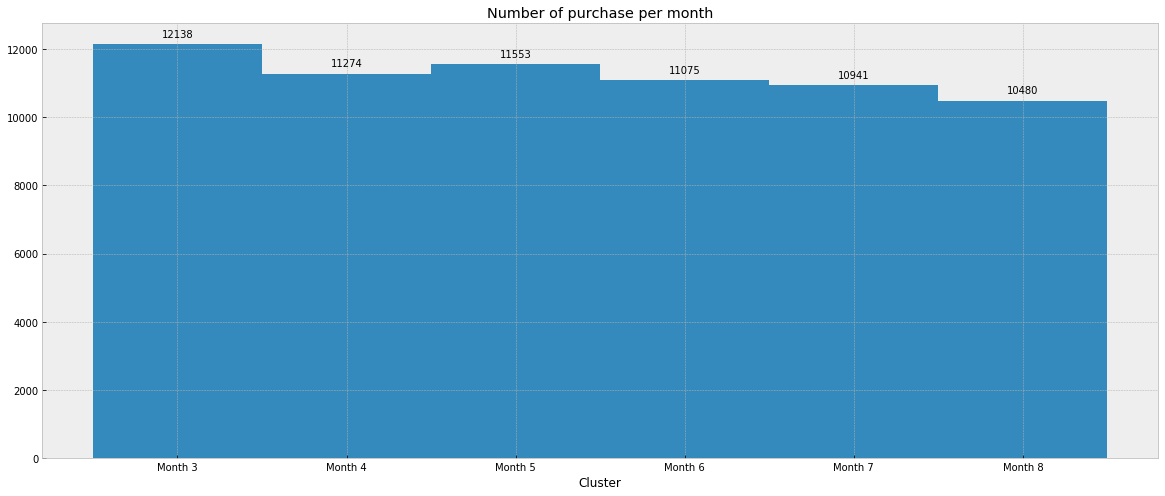

In [108]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=6)
plt.xlabel("Cluster")
plt.title("Number of purchase per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(3, 10)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

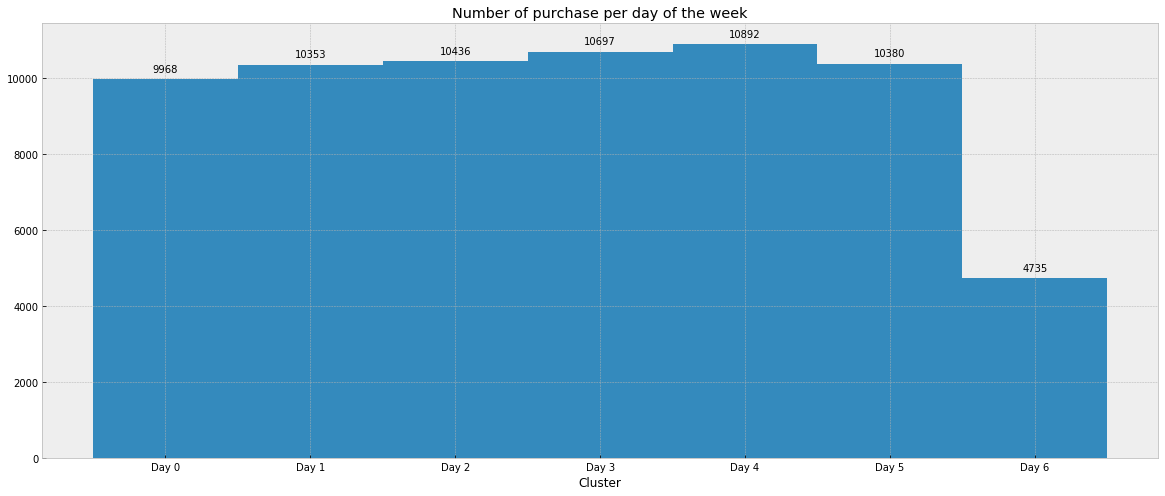

In [109]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of purchase per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

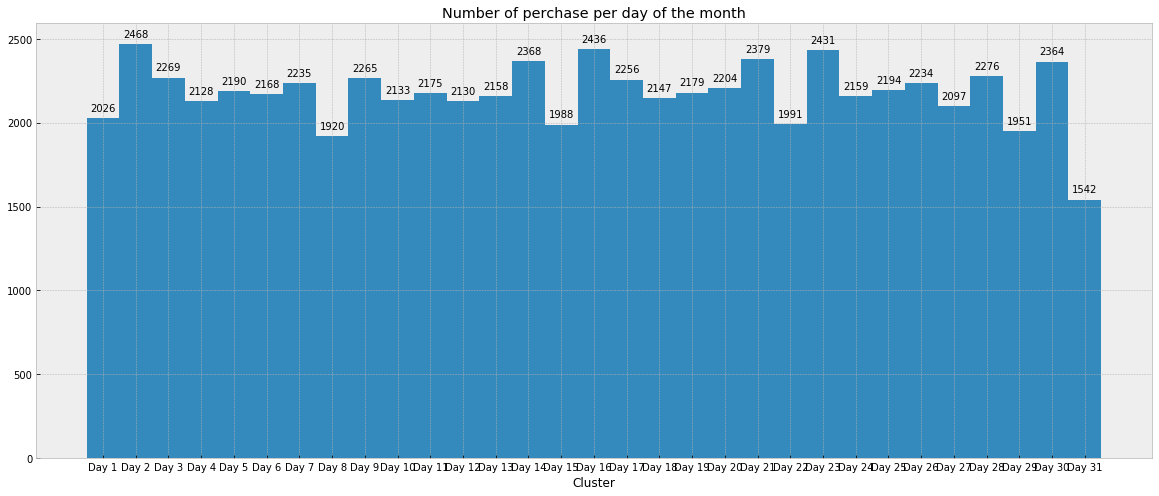

In [110]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of perchase per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

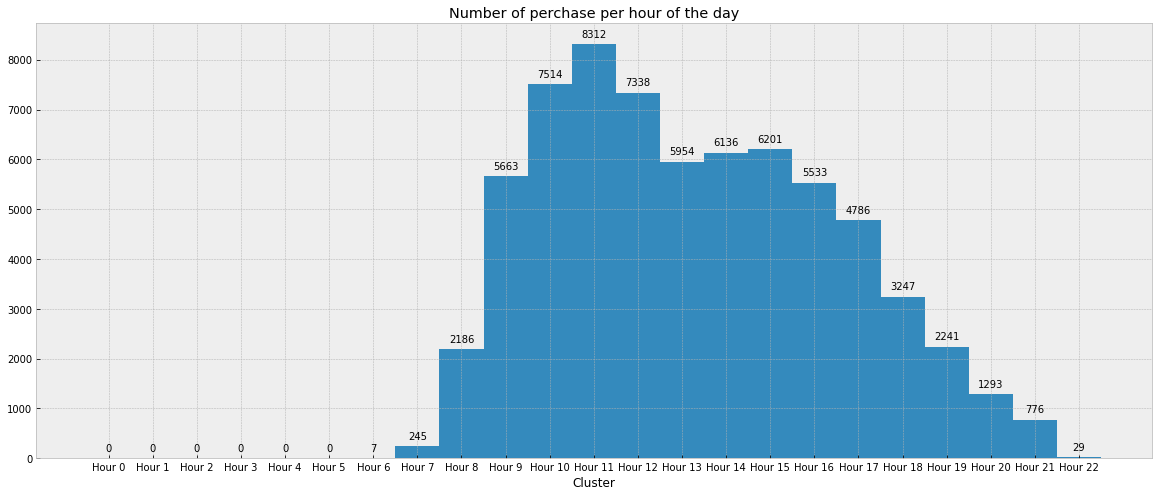

In [111]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=np.arange(0,24,1))
plt.xlabel("Cluster")
plt.title("Number of perchase per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in range(0, 24)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [112]:
print("Key figures:")
print('Min Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==0].mean()[0]))
print('Max Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==0].mean()[1]))
print('Mean Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==0].mean()[2]))
print('Average_spend:'+"%.2f" % (cluster0.groupby(by='customer_number').sum().mean()[1]))
print('Recency:'+"%.2f" % (cluster0.mean()[7]))
print('Frequency:'+"%.2f" % (cluster0.mean()[9]))

Key figures:
Min Basket Spend:1.49
Max Basket Spend:37.71
Mean Basket Spend:10.64
Average_spend:695.95
Recency:3.85
Frequency:70.38


In [113]:
print("TOP 10 spends products :")
print(data0.groupby('category').sum()['spend'].sort_values(ascending=False)[:10])

TOP 10 spends products :
category
TOBACCO                82544.04
DAIRY                  65979.19
DRINKS                 61520.92
FRUIT_VEG              61142.67
GROCERY_FOOD           51275.39
CONFECTIONARY          51122.34
CASHPOINT              49531.22
GROCERY_HEALTH_PETS    48550.10
MEAT                   47331.14
BAKERY                 36085.27
Name: spend, dtype: float64


In [114]:
print("TOP 10 quantities products :")
print(data0.groupby('category').sum()['quantity'].sort_values(ascending=False)[:10])

TOP 10 quantities products :
category
DAIRY                   70339
CONFECTIONARY           66131
FRUIT_VEG               65582
GROCERY_FOOD            58625
BAKERY                  42727
GROCERY_HEALTH_PETS     42564
PREPARED_MEALS          24395
NEWSPAPERS_MAGAZINES    23686
SOFT_DRINKS             23116
MEAT                    21203
Name: quantity, dtype: int32


In [115]:
cluster0_RFMScore['RFMScore'].value_counts()[:10]

222    94
223    78
122    77
123    68
323    48
121    46
322    43
221    40
232    33
224    28
Name: RFMScore, dtype: int64

#### 5.2 Cluster 1

In [116]:
df_final[df_final['cluster']==1]

,min_spend,max_spend,mean_spend,quantity,min_recency,max_recency,frequency,monetary_value,month-3,month-4,...,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS,cluster
customer_number,,,,,,,,,,,,,,,,,,,,,
45,2.18,35.36,17.749394,655,1.0,183.0,33,585.73,6.0,6.0,...,0.0,60.31,17.49,0.00,56.51,0.00,29.65,0.00,8.08,1
61,2.14,43.09,14.807297,499,3.0,182.0,37,547.87,3.0,4.0,...,6.0,121.38,5.55,2.87,12.12,3.04,14.87,0.00,16.38,1
68,5.07,32.12,12.522778,219,2.0,175.0,18,225.41,3.0,4.0,...,0.0,10.77,7.29,0.76,26.86,0.00,2.71,0.00,0.00,1
77,2.50,67.65,17.758000,244,0.0,162.0,20,355.16,1.0,4.0,...,0.0,30.99,1.61,3.40,25.32,0.00,15.05,0.00,1.61,1
81,2.26,55.49,19.703784,525,4.0,178.0,37,729.04,4.0,5.0,...,0.0,44.73,5.44,0.00,45.67,4.52,30.87,0.00,4.53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16234,0.38,15.83,4.670625,266,3.0,183.0,48,224.19,9.0,9.0,...,0.0,0.00,0.80,0.00,3.74,0.00,6.23,0.00,0.00,1
16294,1.76,58.06,19.301364,427,3.0,169.0,44,849.26,3.0,5.0,...,4.0,0.00,16.68,0.00,54.38,0.00,24.96,454.34,4.32,1
16301,1.98,15.95,5.986429,268,4.0,182.0,42,251.43,11.0,7.0,...,10.0,0.00,7.30,0.00,2.57,5.01,15.78,0.00,2.11,1


In [117]:
cluster1.head()

,customer_number,purchase_time,quantity,spend,Month,Weekday,Day,Hour,min_recency,max_recency,frequency,monetary_value,RFMScore,count
56,45,2007-03-01 13:51:00,25,20.20,3,3,1,13,1.0,183.0,33,585.73,233,1
57,45,2007-03-05 16:27:00,2,2.18,3,0,5,16,1.0,183.0,33,585.73,233,1
58,45,2007-03-08 10:10:00,19,20.16,3,3,8,10,1.0,183.0,33,585.73,233,1
59,45,2007-03-15 10:06:00,21,19.91,3,3,15,10,1.0,183.0,33,585.73,233,1
60,45,2007-03-22 16:55:00,33,35.36,3,3,22,16,1.0,183.0,33,585.73,233,1


In [118]:
custom_aggregation = {}
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]
cluster1_RFMScore = cluster1.groupby("customer_number").agg(custom_aggregation)

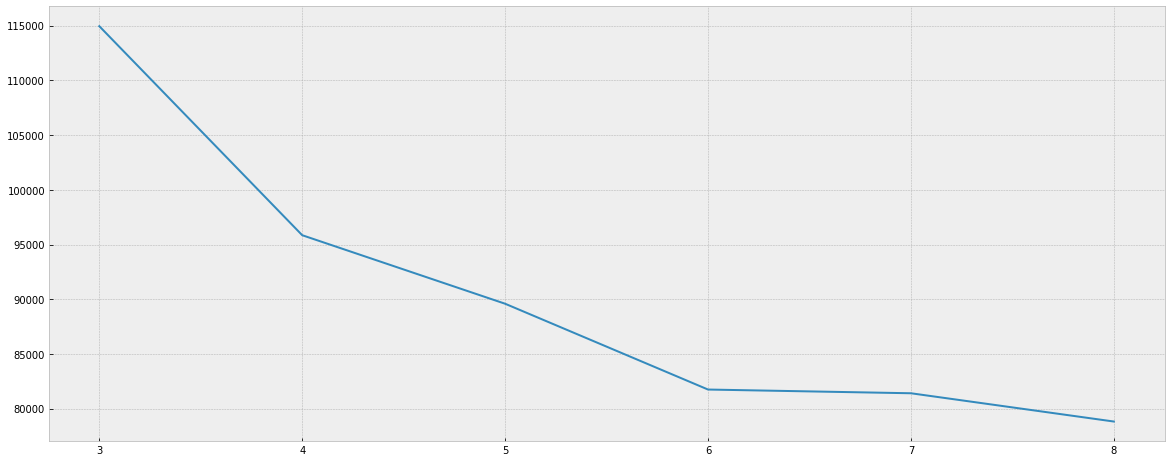

In [119]:
plt.figure(figsize = (20,8))
plt.plot(cluster1.groupby(['Month']).sum()['spend'])

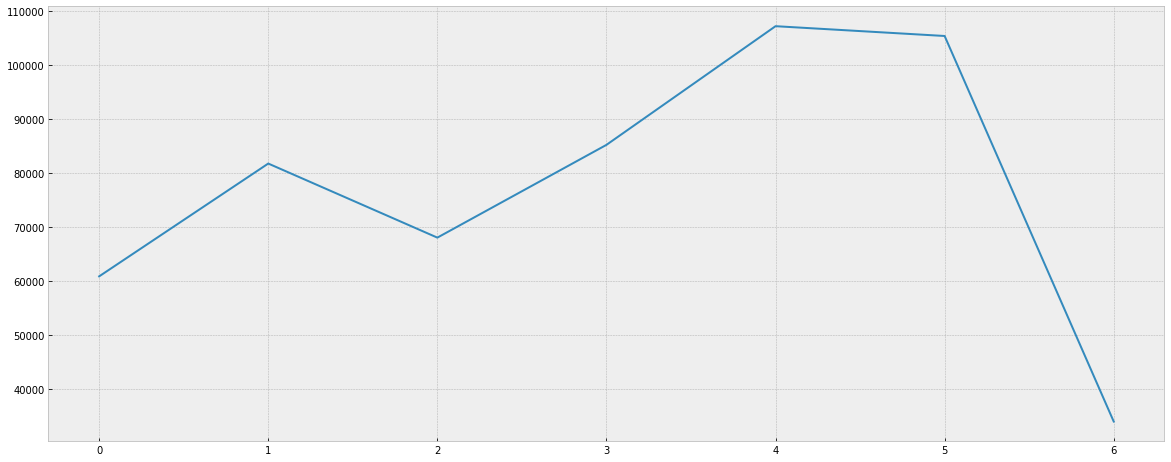

In [120]:
plt.figure(figsize = (20,8))
plt.plot(cluster1.groupby(['Weekday']).sum()['spend'])

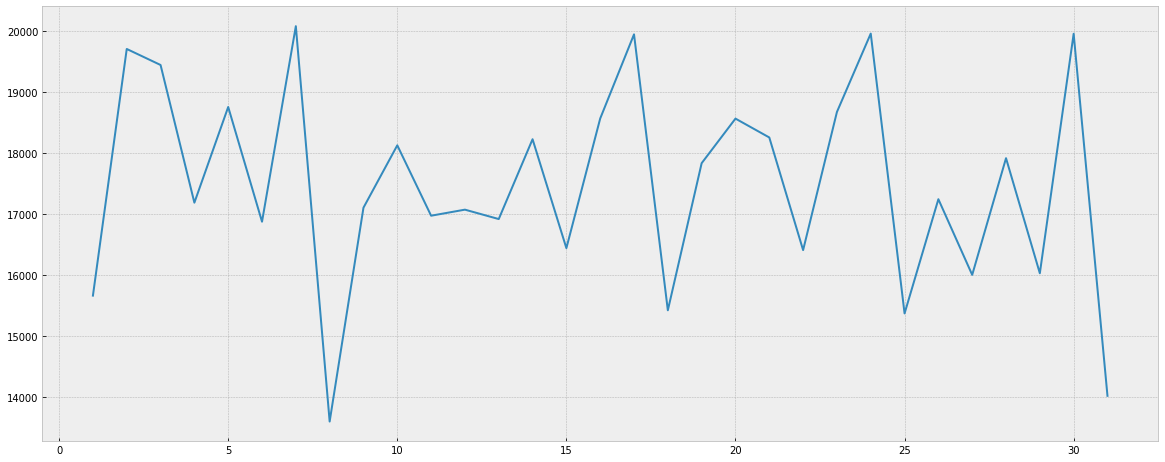

In [121]:
plt.figure(figsize = (20,8))
plt.plot(cluster1.groupby(['Day']).sum()['spend'])

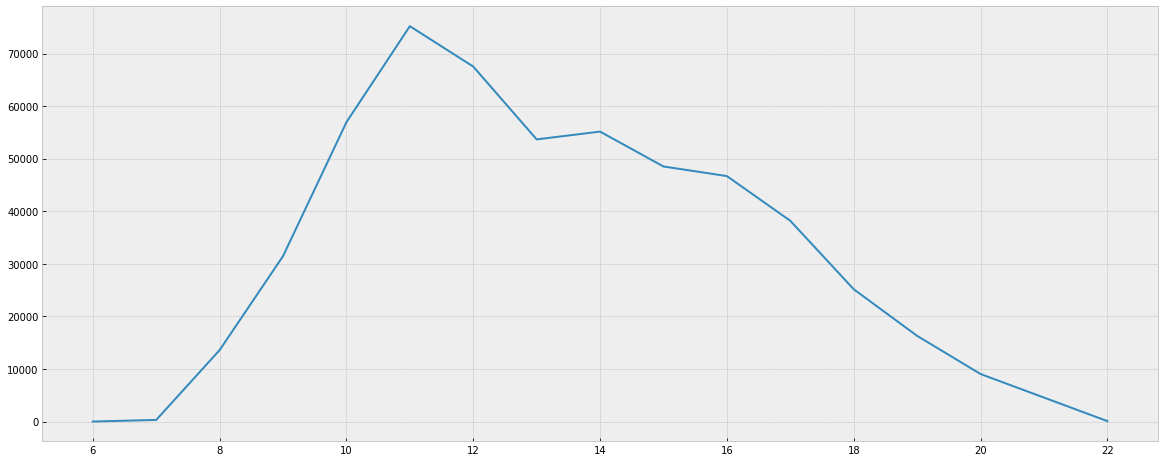

In [122]:
plt.figure(figsize = (20,8))
plt.plot(cluster1.groupby(['Hour']).sum()['spend'])

In [123]:
cluster1['Month'].value_counts()

3    7216
4    5894
5    5472
7    5081
6    5059
8    4882
Name: Month, dtype: int64

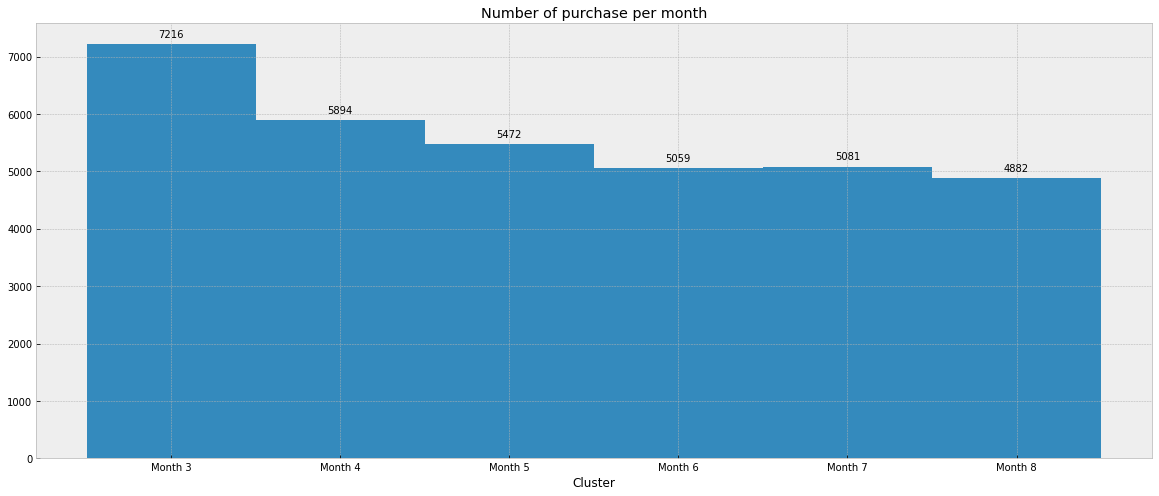

In [124]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Month'], bins=6)
plt.xlabel("Cluster")
plt.title("Number of purchase per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(3, 10)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

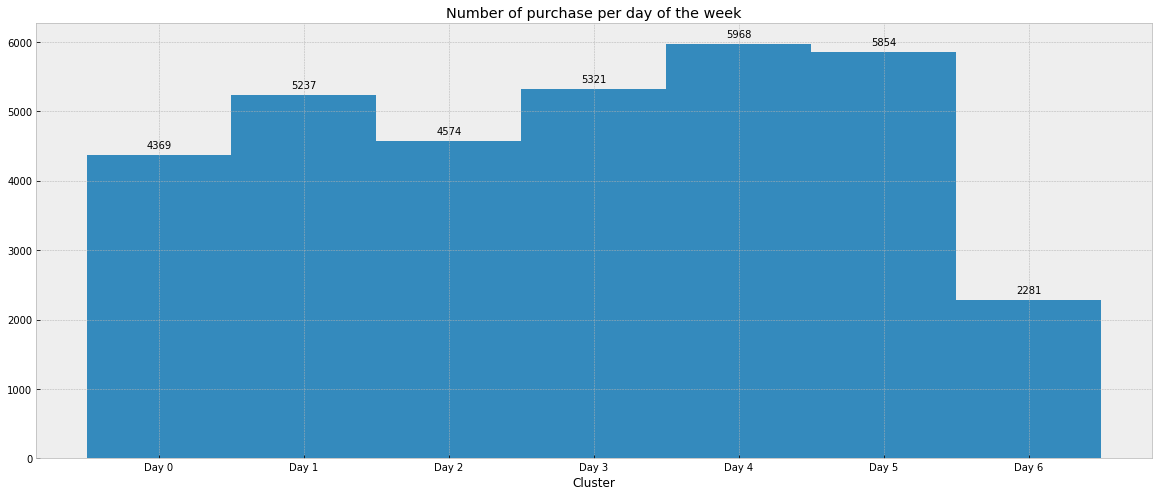

In [125]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of purchase per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

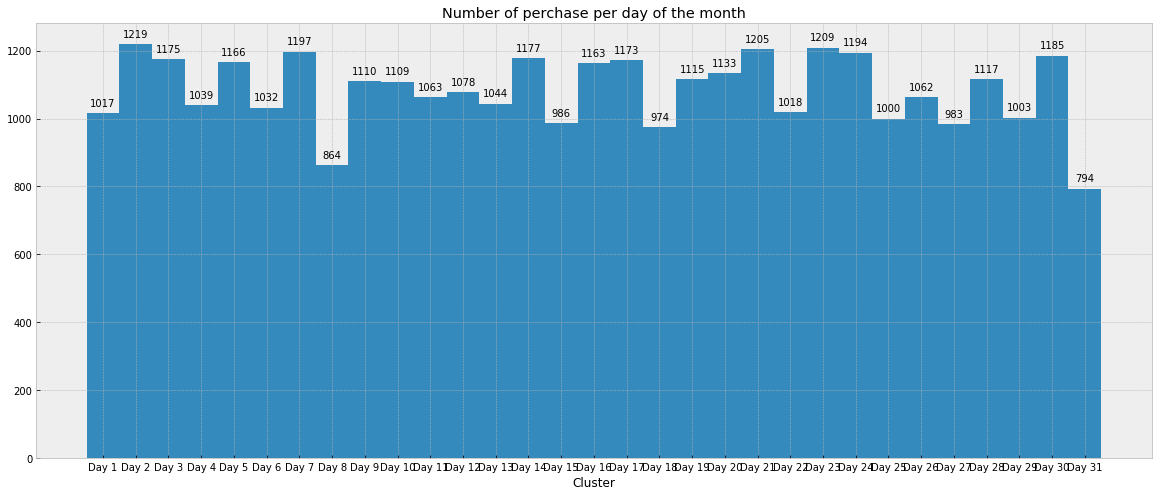

In [126]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of perchase per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

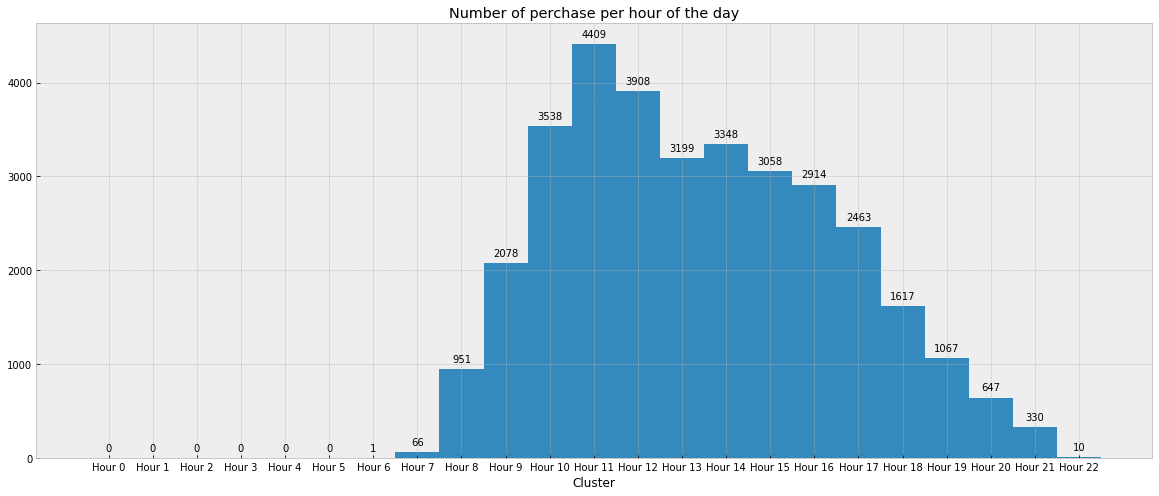

In [127]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Hour'], bins=np.arange(0,24,1))
plt.xlabel("Cluster")
plt.title("Number of perchase per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in range(0, 24)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [128]:
print("Key figures:")
print('Min Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==1].mean()[0]))
print('Max Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==1].mean()[1]))
print('Mean Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==1].mean()[2]))
print('Average_spend:'+"%.2f" % (cluster1.groupby(by='customer_number').sum().mean()[1]))
print('Recency:'+"%.2f" % (cluster1.mean()[7]))
print('Frequency:'+"%.2f" % (cluster1.mean()[9]))

Key figures:
Min Basket Spend:3.82
Max Basket Spend:45.13
Mean Basket Spend:17.87
Average_spend:448.26
Recency:11.09
Frequency:32.33


In [129]:
print("TOP 10 spends products :")
print(data1.groupby('category').sum()['spend'].sort_values(ascending=False)[:10])

TOP 10 spends products :
category
FRUIT_VEG              56459.94
DAIRY                  54373.67
GROCERY_FOOD           49578.94
GROCERY_HEALTH_PETS    48350.87
DRINKS                 43453.34
MEAT                   43284.15
CONFECTIONARY          42892.69
TOBACCO                39944.50
PREPARED_MEALS         28437.86
FROZEN                 28260.62
Name: spend, dtype: float64


In [130]:
print("TOP 10 quantities products :")
print(data1.groupby('category').sum()['quantity'].sort_values(ascending=False)[:10])

TOP 10 quantities products :
category
FRUIT_VEG              56688
DAIRY                  55585
GROCERY_FOOD           53785
CONFECTIONARY          48380
GROCERY_HEALTH_PETS    37484
BAKERY                 29983
PREPARED_MEALS         20289
MEAT                   18462
FROZEN                 18075
SOFT_DRINKS            17635
Name: quantity, dtype: int32


In [131]:
cluster1_RFMScore['RFMScore'].value_counts()[:10]

444    252
344     92
443     67
244     63
233     55
333     53
343     46
434     43
144     43
442     41
Name: RFMScore, dtype: int64

#### 5.3 Cluster 2

In [132]:
df_final[df_final['cluster']==2].head()

,min_spend,max_spend,mean_spend,quantity,min_recency,max_recency,frequency,monetary_value,month-3,month-4,...,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS,cluster
customer_number,,,,,,,,,,,,,,,,,,,,,
263,0.57,21.46,5.470039,1315,0.0,183.0,258,1411.27,40.0,42.0,...,196.0,167.97,180.85,0.00,121.30,9.62,2.01,0.0,165.82,2
921,0.44,62.48,7.335956,1068,1.0,183.0,183,1342.48,44.0,39.0,...,1.0,21.84,21.04,0.00,10.79,33.97,137.96,0.0,12.98,2
1081,0.35,15.75,2.070718,417,0.0,183.0,195,403.79,26.0,34.0,...,0.0,22.38,55.40,1.69,14.47,1.18,9.35,0.0,0.00,2
1292,0.35,56.35,4.376514,857,11.0,183.0,218,954.08,32.0,25.0,...,212.0,87.00,163.00,1.52,35.94,0.00,6.38,0.0,1.98,2
1759,0.18,45.79,5.193317,1134,0.0,171.0,199,1033.47,21.0,19.0,...,64.0,53.55,158.33,0.00,43.15,10.31,10.88,0.0,3.17,2


In [133]:
cluster2.head()

,customer_number,purchase_time,quantity,spend,Month,Weekday,Day,Hour,min_recency,max_recency,frequency,monetary_value,RFMScore,count
2748,263,2007-03-01 07:48:00,3,1.84,3,3,1,7,0.0,183.0,258,1411.27,111,1
2749,263,2007-03-01 09:19:00,2,0.89,3,3,1,9,0.0,183.0,258,1411.27,111,1
2750,263,2007-03-02 07:55:00,5,3.99,3,4,2,7,0.0,183.0,258,1411.27,111,1
2751,263,2007-03-03 07:57:00,5,5.81,3,5,3,7,0.0,183.0,258,1411.27,111,1
2752,263,2007-03-04 08:17:00,4,2.51,3,6,4,8,0.0,183.0,258,1411.27,111,1


In [134]:
custom_aggregation = {}
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]
cluster2_RFMScore = cluster2.groupby("customer_number").agg(custom_aggregation)

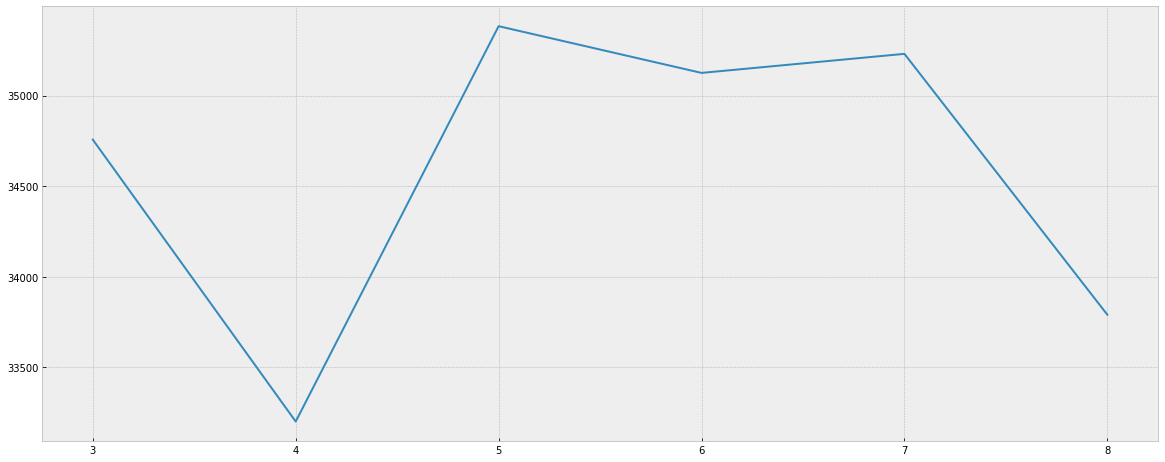

In [135]:
plt.figure(figsize = (20,8))
plt.plot(cluster2.groupby(['Month']).sum()['spend'])

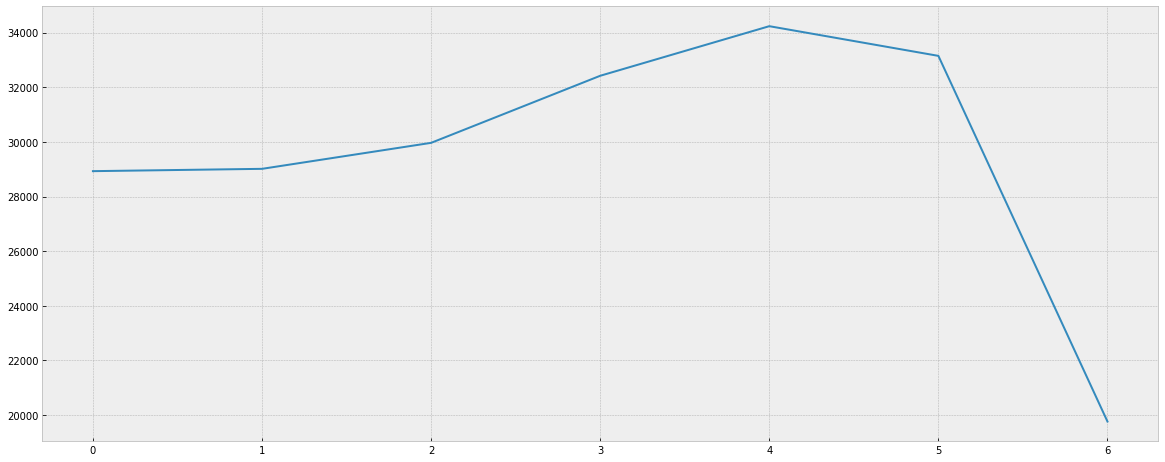

In [136]:
plt.figure(figsize = (20,8))
plt.plot(cluster2.groupby(['Weekday']).sum()['spend'])

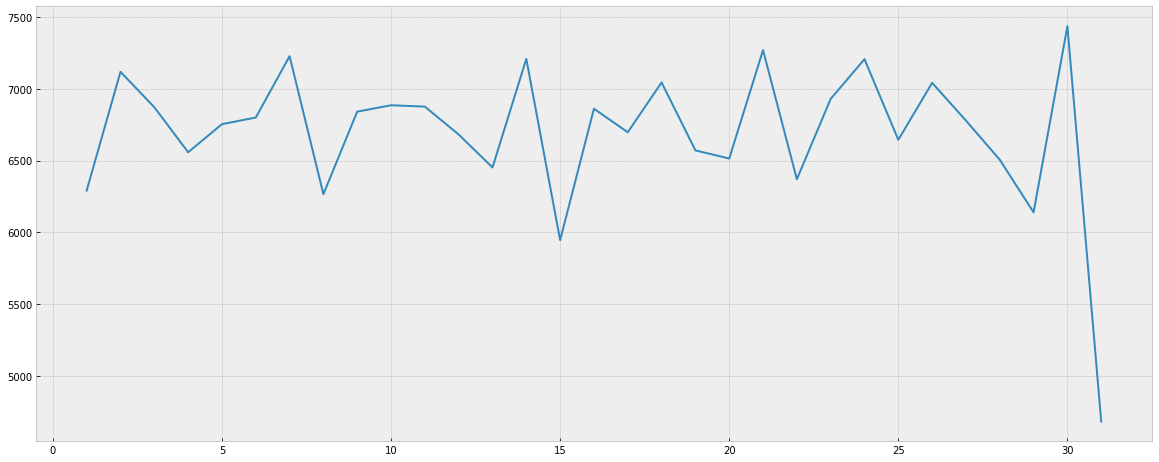

In [137]:
plt.figure(figsize = (20,8))
plt.plot(cluster2.groupby(['Day']).sum()['spend'])

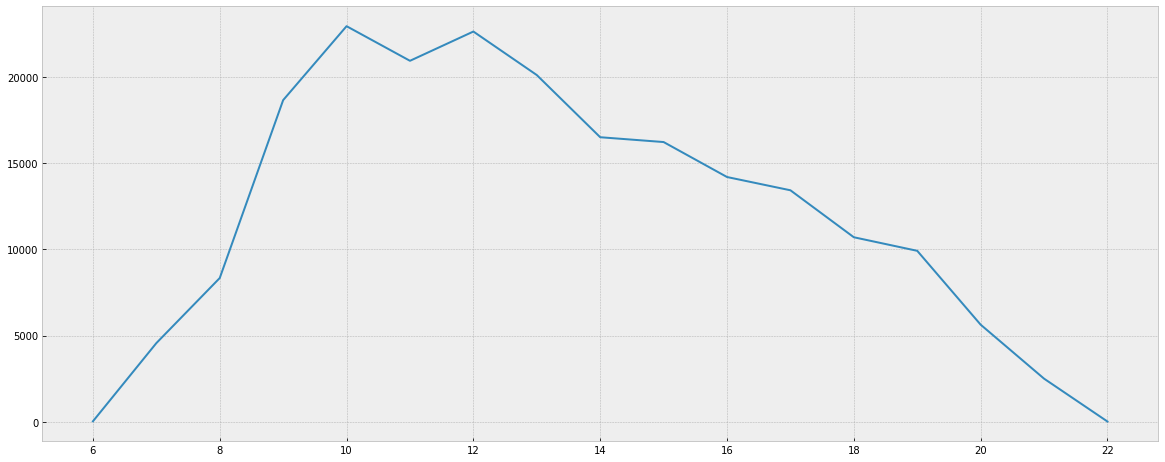

In [138]:
plt.figure(figsize = (20,8))
plt.plot(cluster2.groupby(['Hour']).sum()['spend'])

In [139]:
cluster2['Month'].value_counts()

5    4129
7    4108
8    4002
6    3991
3    3975
4    3928
Name: Month, dtype: int64

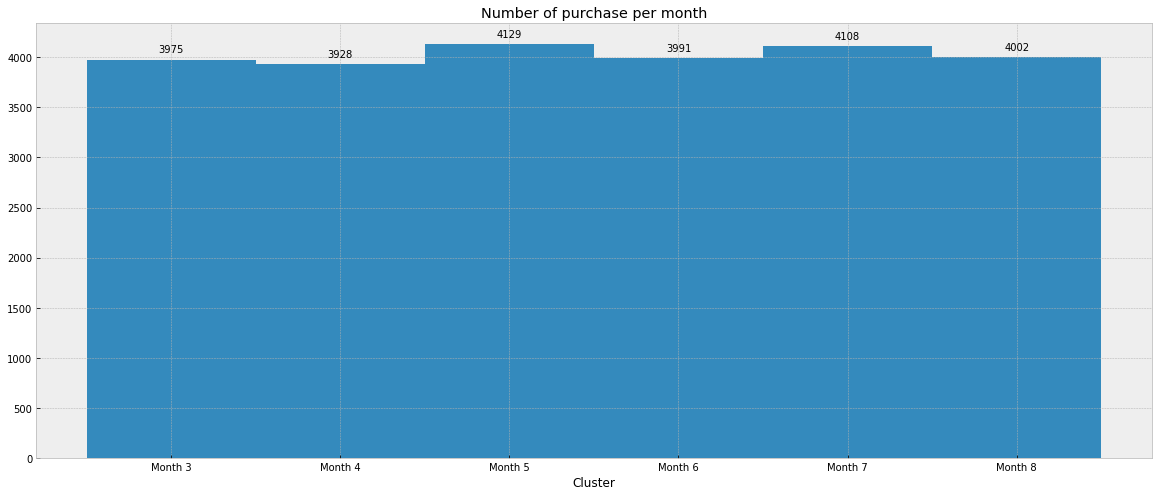

In [140]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster2['Month'], bins=6)
plt.xlabel("Cluster")
plt.title("Number of purchase per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(3, 10)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

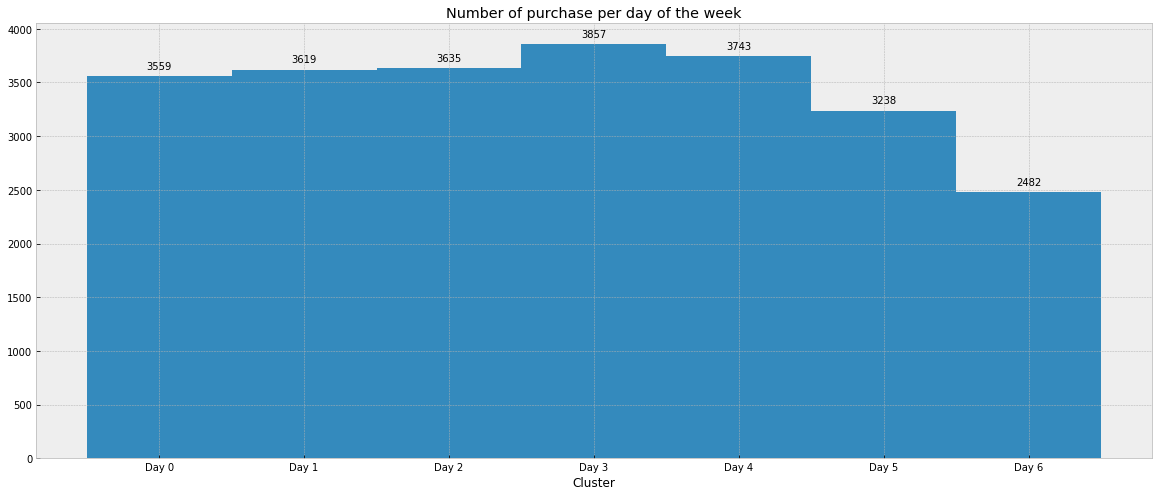

In [141]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster2['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of purchase per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

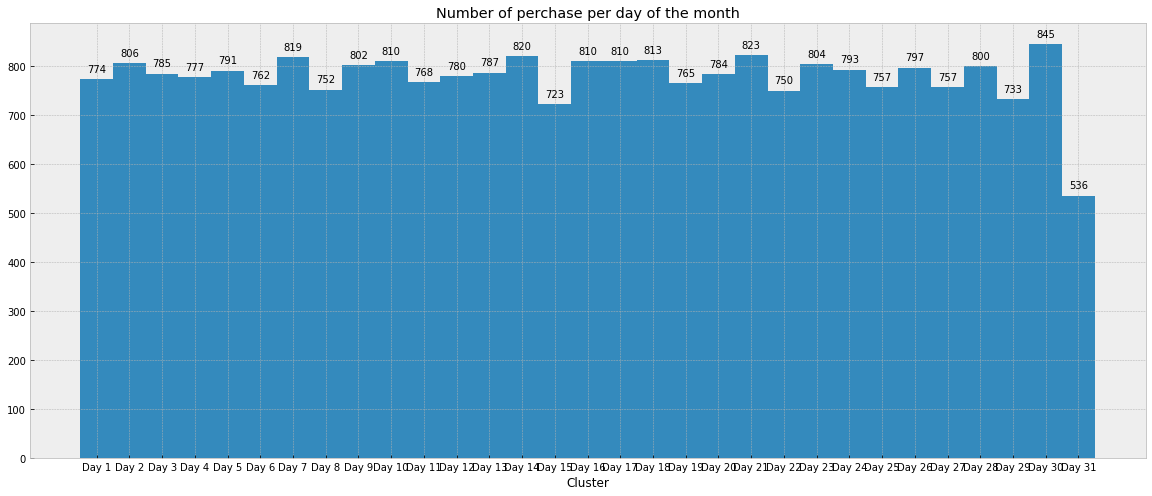

In [142]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster2['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of perchase per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

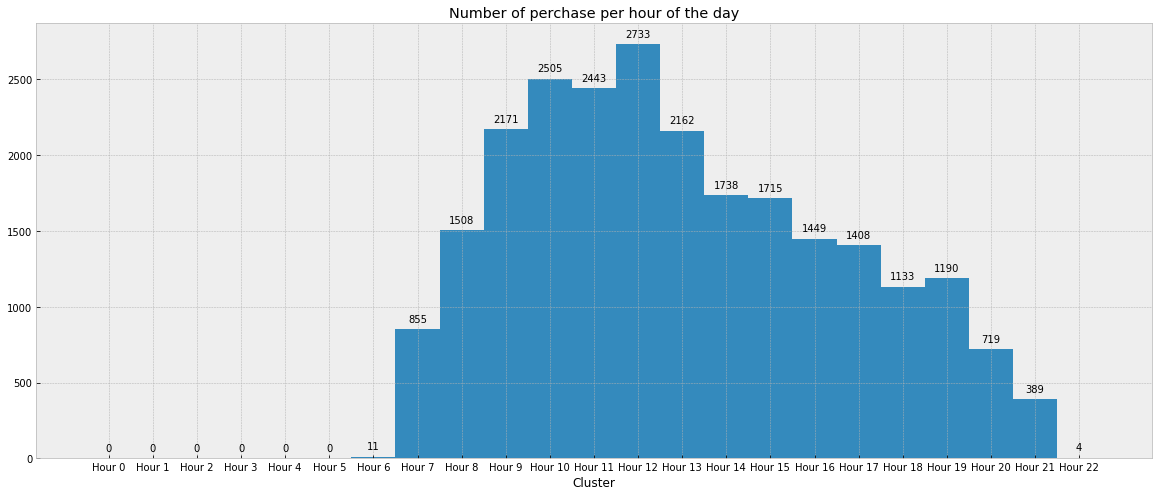

In [143]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster2['Hour'], bins=np.arange(0,24,1))
plt.xlabel("Cluster")
plt.title("Number of perchase per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in range(0, 24)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [144]:
print("Key figures:")
print('Min Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==2].mean()[0]))
print('Max Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==2].mean()[1]))
print('Mean Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==2].mean()[2]))
print('Average_spend:'+"%.2f" % (cluster2.groupby(by='customer_number').sum().mean()[1]))
print('Recency:'+"%.2f" % (cluster2.mean()[7]))
print('Frequency:'+"%.2f" % (cluster2.mean()[9]))

Key figures:
Min Basket Spend:0.87
Max Basket Spend:39.99
Mean Basket Spend:8.84
Average_spend:1836.15
Recency:0.58
Frequency:224.36


In [145]:
print("TOP 10 spends products :")
print(data2.groupby('category').sum()['spend'].sort_values(ascending=False)[:10])

TOP 10 spends products :
category
TOBACCO                48927.90
DRINKS                 17905.10
DAIRY                  14908.13
CASHPOINT              14488.07
CONFECTIONARY          12329.54
GROCERY_HEALTH_PETS    12309.35
GROCERY_FOOD           11517.37
FRUIT_VEG              11268.83
MEAT                   10517.98
BAKERY                  9690.88
Name: spend, dtype: float64


In [146]:
print("TOP 10 quantities products :")
print(data2.groupby('category').sum()['quantity'].sort_values(ascending=False)[:10])

TOP 10 quantities products :
category
CONFECTIONARY           17790
DAIRY                   16211
GROCERY_FOOD            13471
TOBACCO                 12596
FRUIT_VEG               12118
NEWSPAPERS_MAGAZINES    11602
BAKERY                  11378
GROCERY_HEALTH_PETS     10028
SOFT_DRINKS              8725
PREPARED_MEALS           5223
Name: quantity, dtype: int32


In [147]:
cluster2_RFMScore['RFMScore'].value_counts()

111    73
112    16
211    14
113     3
212     2
411     2
114     1
412     1
311     1
Name: RFMScore, dtype: int64

#### 5.4 Cluster 3

In [148]:
df_final[df_final['cluster']==3].head()

,min_spend,max_spend,mean_spend,quantity,min_recency,max_recency,frequency,monetary_value,month-3,month-4,...,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS,cluster
customer_number,,,,,,,,,,,,,,,,,,,,,
67,5.25,110.03,35.204000,1055,2.0,182.0,45,1584.18,12.0,3.0,...,0.0,134.67,28.39,32.28,20.64,11.15,50.75,0.0,7.33,3
71,3.39,54.85,29.375714,970,3.0,181.0,42,1233.78,7.0,8.0,...,0.0,141.86,14.07,2.79,0.49,2.51,51.15,0.0,6.64,3
157,3.43,49.10,33.775455,1208,2.0,181.0,55,1857.65,9.0,8.0,...,0.0,52.54,10.20,9.42,107.95,14.34,15.53,0.0,0.00,3
244,2.36,62.41,21.248730,1045,6.0,183.0,63,1338.67,6.0,12.0,...,0.0,76.00,21.31,1.27,31.38,18.97,21.10,0.0,11.71,3
247,32.01,57.91,44.439630,1018,0.0,182.0,27,1199.87,5.0,4.0,...,0.0,20.01,104.20,0.00,4.51,0.00,32.07,0.0,0.00,3


In [149]:
cluster3.head()

,customer_number,purchase_time,quantity,spend,Month,Weekday,Day,Hour,min_recency,max_recency,frequency,monetary_value,RFMScore,count
233,67,2007-03-02 11:44:00,26,36.46,3,4,2,11,2.0,182.0,45,1584.18,231,1
234,67,2007-03-03 17:47:00,27,50.25,3,5,3,17,2.0,182.0,45,1584.18,231,1
235,67,2007-03-06 17:48:00,18,17.60,3,1,6,17,2.0,182.0,45,1584.18,231,1
236,67,2007-03-07 19:39:00,16,25.52,3,2,7,19,2.0,182.0,45,1584.18,231,1
237,67,2007-03-09 21:04:00,19,23.25,3,4,9,21,2.0,182.0,45,1584.18,231,1


In [150]:
custom_aggregation = {}
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]
cluster3_RFMScore = cluster3.groupby("customer_number").agg(custom_aggregation)

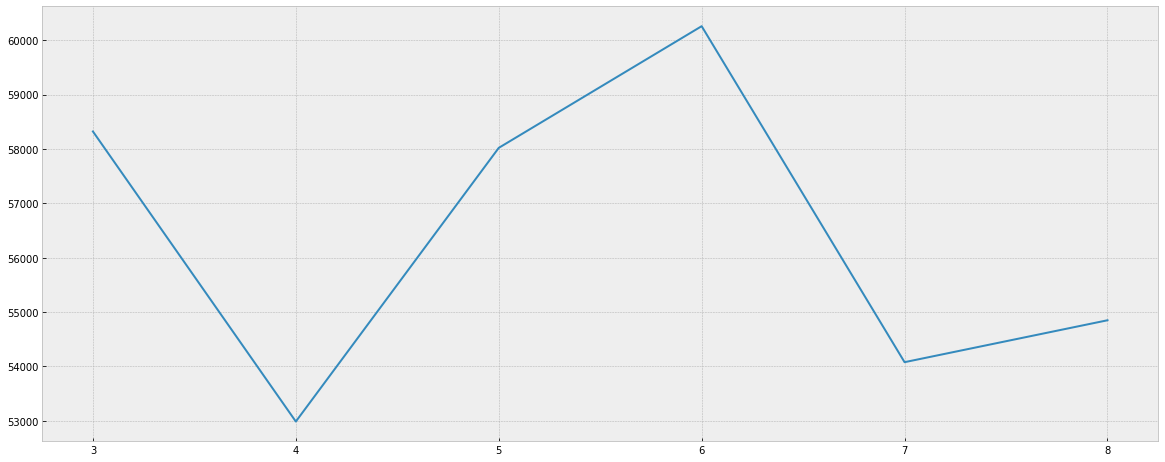

In [151]:
plt.figure(figsize = (20,8))
plt.plot(cluster3.groupby(['Month']).sum()['spend'])

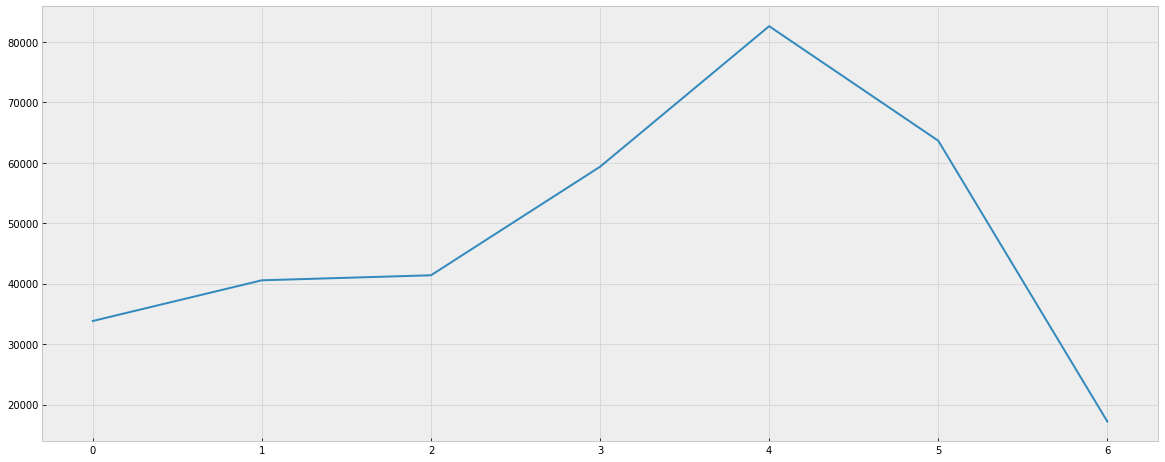

In [152]:
plt.figure(figsize = (20,8))
plt.plot(cluster3.groupby(['Weekday']).sum()['spend'])

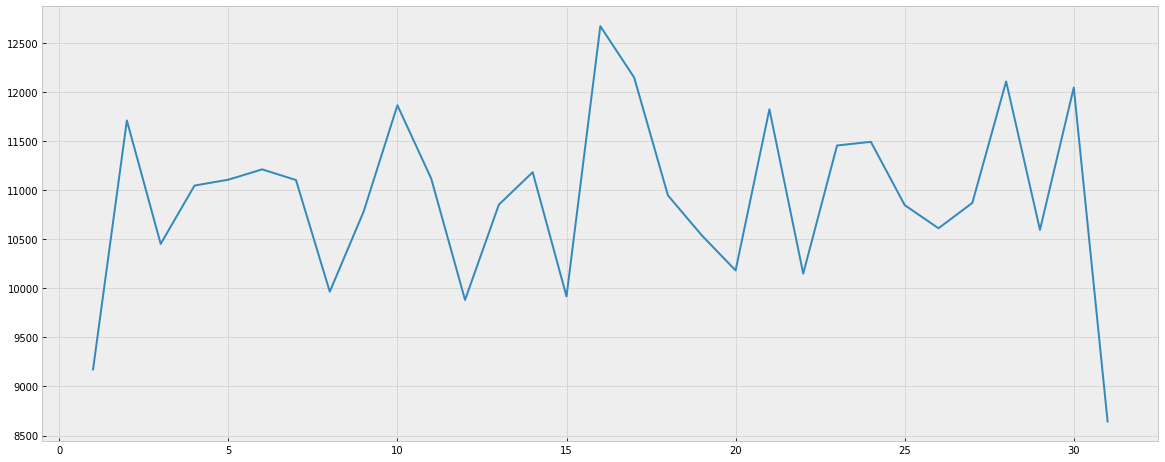

In [153]:
plt.figure(figsize = (20,8))
plt.plot(cluster3.groupby(['Day']).sum()['spend'])

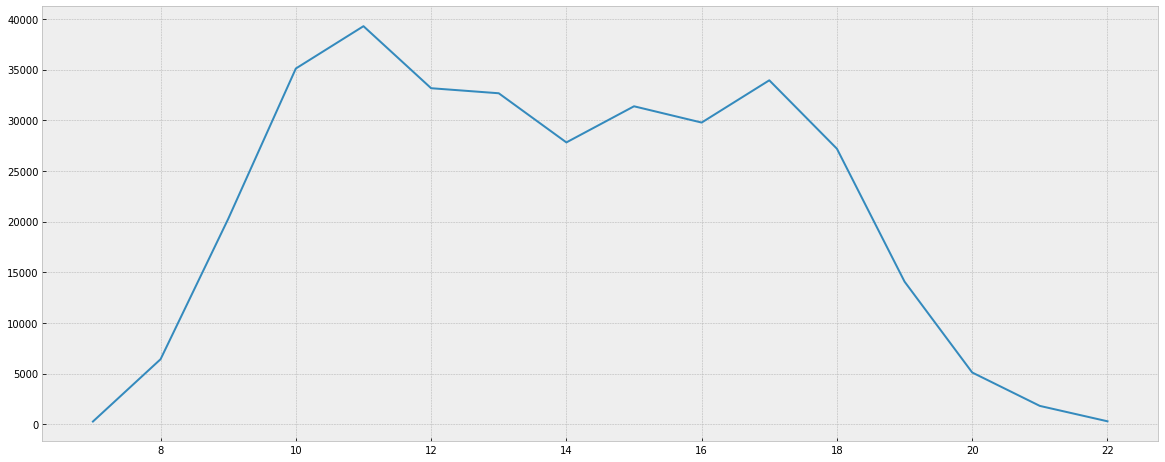

In [154]:
plt.figure(figsize = (20,8))
plt.plot(cluster3.groupby(['Hour']).sum()['spend'])

In [155]:
cluster3['Month'].value_counts()

3    2031
6    1993
5    1964
8    1884
7    1847
4    1837
Name: Month, dtype: int64

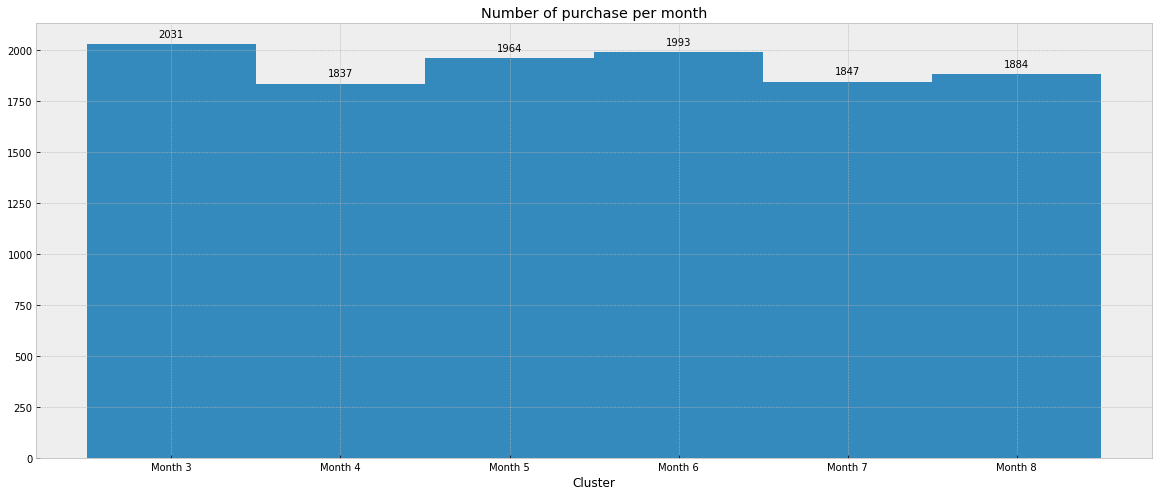

In [156]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster3['Month'], bins=6)
plt.xlabel("Cluster")
plt.title("Number of purchase per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(3, 10)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

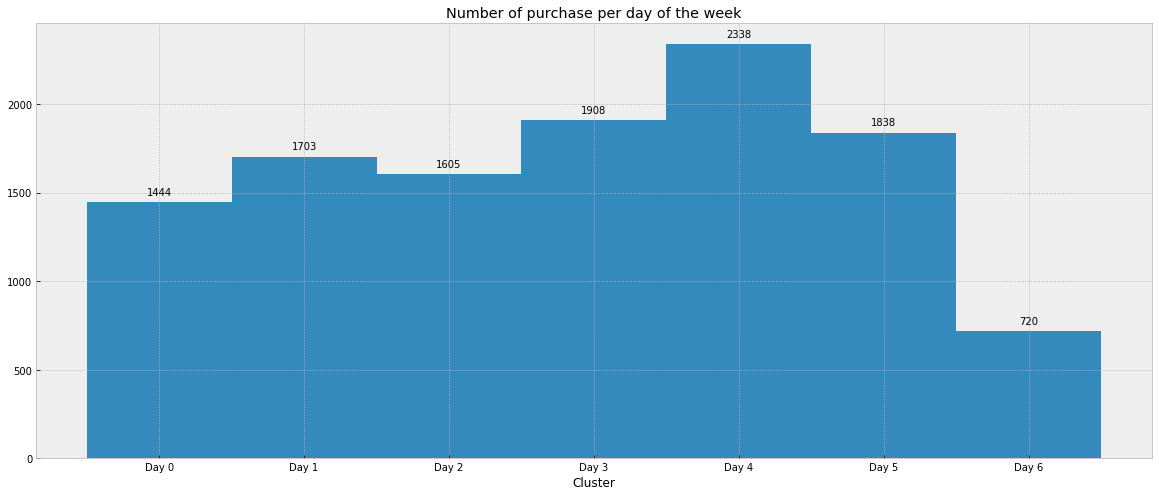

In [157]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster3['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of purchase per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

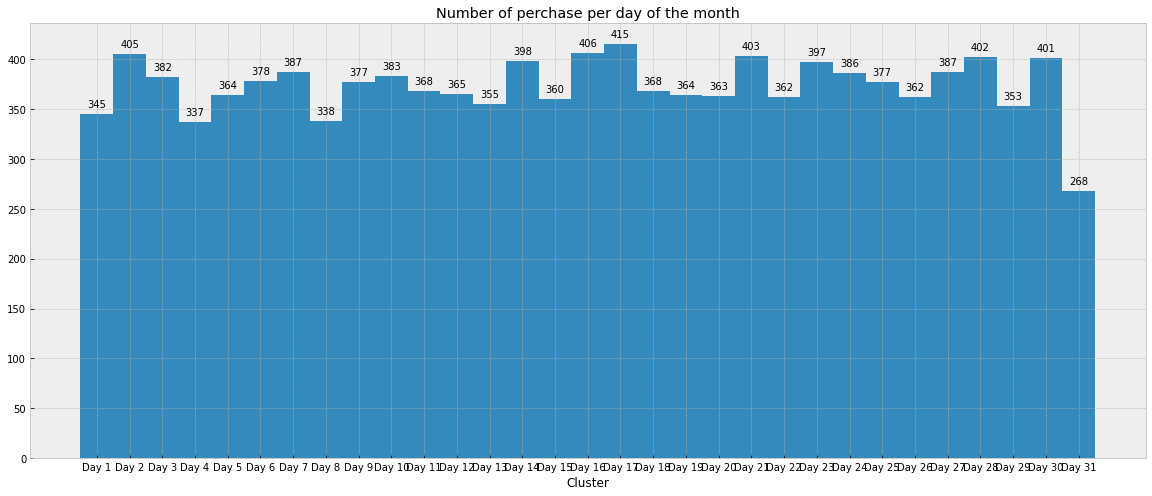

In [158]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster3['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of perchase per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

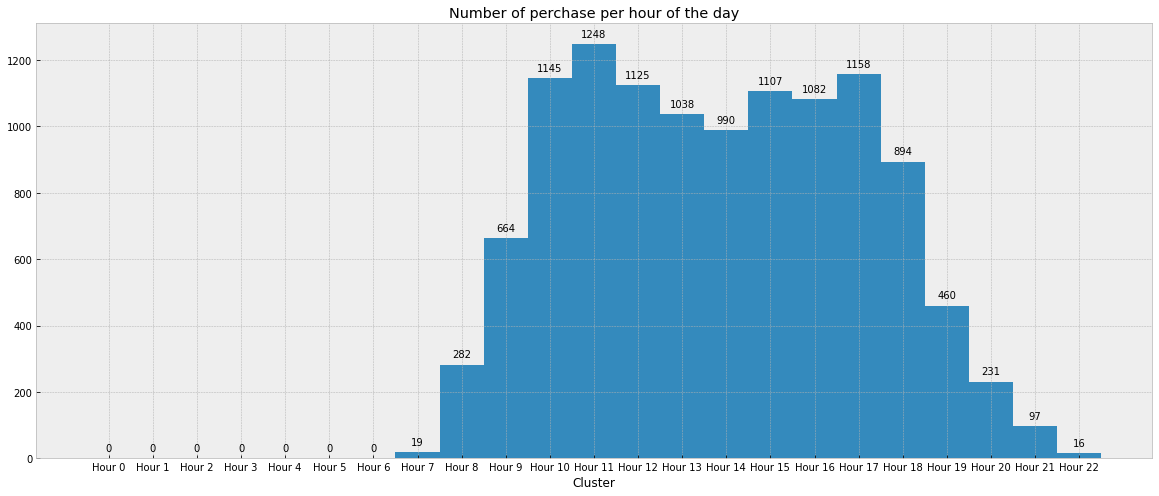

In [159]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster3['Hour'], bins=np.arange(0,24,1))
plt.xlabel("Cluster")
plt.title("Number of perchase per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in range(0, 24)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [160]:
print("Key figures:")
print('Min Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==3].mean()[0]))
print('Max Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==3].mean()[1]))
print('Mean Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==3].mean()[2]))
print('Average_spend:'+"%.2f" % (cluster3.groupby(by='customer_number').sum().mean()[1]))
print('Recency:'+"%.2f" % (cluster3.mean()[7]))
print('Frequency:'+"%.2f" % (cluster3.mean()[9]))

Key figures:
Min Basket Spend:4.34
Max Basket Spend:91.90
Mean Basket Spend:34.62
Average_spend:1718.38
Recency:3.38
Frequency:69.30


In [161]:
print("TOP 10 spends products :")
print(data3.groupby('category').sum()['spend'].sort_values(ascending=False)[:10])

TOP 10 spends products :
category
GROCERY_HEALTH_PETS    38963.21
FRUIT_VEG              37785.70
MEAT                   33193.61
DAIRY                  33149.59
GROCERY_FOOD           32655.96
CONFECTIONARY          31773.07
FROZEN                 20325.06
PREPARED_MEALS         18310.63
DRINKS                 17978.42
BAKERY                 17487.19
Name: spend, dtype: float64


In [162]:
print("TOP 10 quantities products :")
print(data3.groupby('category').sum()['quantity'].sort_values(ascending=False)[:10])

TOP 10 quantities products :
category
CONFECTIONARY          36183
FRUIT_VEG              35595
GROCERY_FOOD           34216
DAIRY                  32019
GROCERY_HEALTH_PETS    28733
BAKERY                 18531
SOFT_DRINKS            13747
MEAT                   13288
FROZEN                 12489
PREPARED_MEALS         12297
Name: quantity, dtype: int32


In [163]:
cluster3_RFMScore['RFMScore'].value_counts()[:10]

221    32
121    21
231    20
111    18
331    16
131    16
321    13
241     9
141     9
421     9
Name: RFMScore, dtype: int64

#### 5.5 Cluster 4

In [164]:
df_final[df_final['cluster']==4].head()

,min_spend,max_spend,mean_spend,quantity,min_recency,max_recency,frequency,monetary_value,month-3,month-4,...,LOTTERY,MEAT,NEWSPAPERS_MAGAZINES,PRACTICAL_ITEMS,PREPARED_MEALS,SEASONAL_GIFTING,SOFT_DRINKS,TOBACCO,WORLD_FOODS,cluster
customer_number,,,,,,,,,,,,,,,,,,,,,
156,1.61,23.96,10.186842,807,0.0,183.0,95,967.75,14.0,13.0,...,0.0,25.43,35.28,25.77,17.27,12.24,17.13,0.0,2.03,4
182,0.60,11.53,3.814608,551,0.0,181.0,102,389.09,17.0,17.0,...,2.0,4.58,88.34,0.00,5.43,2.25,1.01,0.0,10.10,4
186,0.92,17.09,3.580566,965,0.0,183.0,159,569.31,24.0,26.0,...,0.0,6.17,80.20,0.00,104.82,0.00,21.00,0.0,27.61,4
206,0.84,54.25,9.349478,1043,1.0,183.0,115,1075.19,26.0,15.0,...,0.0,159.84,2.56,0.00,66.65,10.52,128.21,0.0,5.58,4
218,0.26,23.38,5.653089,675,0.0,183.0,123,695.33,20.0,23.0,...,0.0,18.02,16.00,6.44,17.35,12.99,3.45,0.0,3.13,4


In [165]:
cluster4.head()

,customer_number,purchase_time,quantity,spend,Month,Weekday,Day,Hour,min_recency,max_recency,frequency,monetary_value,RFMScore,count
1026,156,2007-03-01 11:51:00,6,9.11,3,3,1,11,0.0,183.0,95,967.75,111,1
1027,156,2007-03-02 13:49:00,7,7.38,3,4,2,13,0.0,183.0,95,967.75,111,1
1028,156,2007-03-03 11:42:00,3,3.78,3,5,3,11,0.0,183.0,95,967.75,111,1
1029,156,2007-03-05 14:58:00,9,8.27,3,0,5,14,0.0,183.0,95,967.75,111,1
1030,156,2007-03-07 14:56:00,7,12.95,3,2,7,14,0.0,183.0,95,967.75,111,1


In [166]:
custom_aggregation = {}
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]
cluster4_RFMScore = cluster4.groupby("customer_number").agg(custom_aggregation)

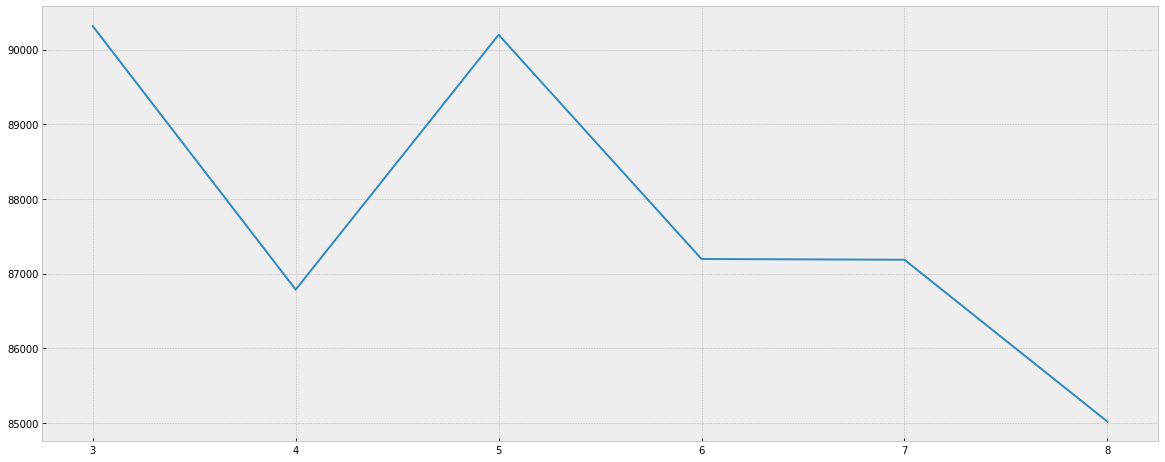

In [167]:
plt.figure(figsize = (20,8))
plt.plot(cluster4.groupby(['Month']).sum()['spend'])

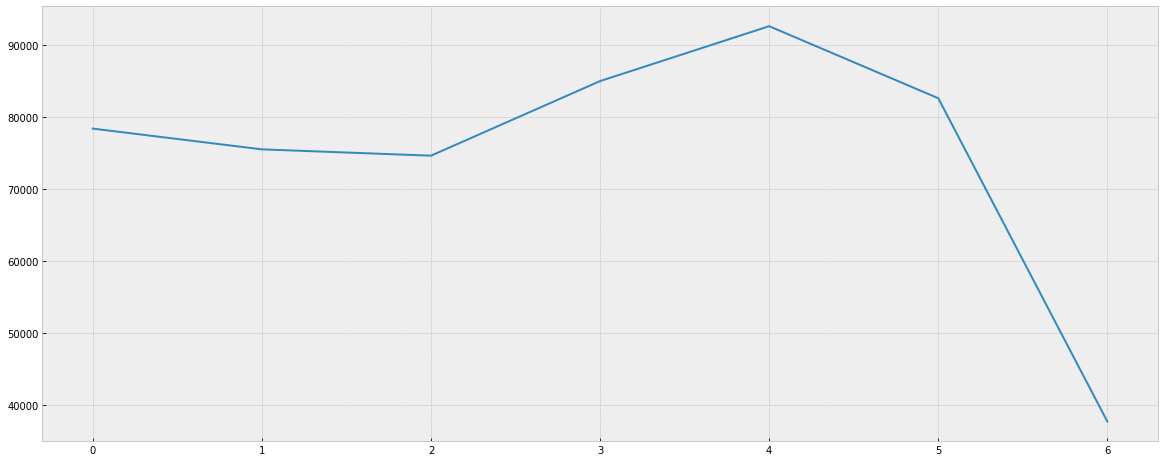

In [168]:
plt.figure(figsize = (20,8))
plt.plot(cluster4.groupby(['Weekday']).sum()['spend'])

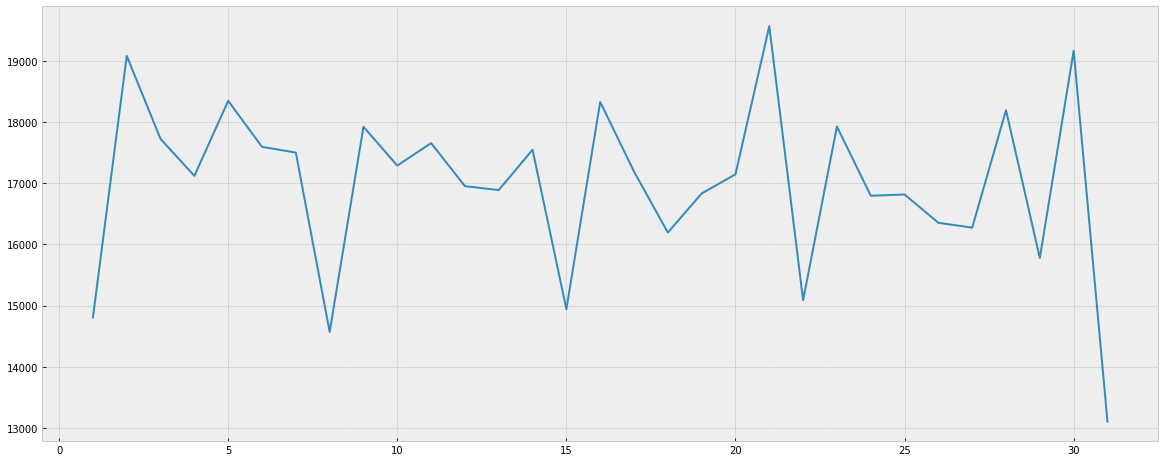

In [169]:
plt.figure(figsize = (20,8))
plt.plot(cluster4.groupby(['Day']).sum()['spend'])

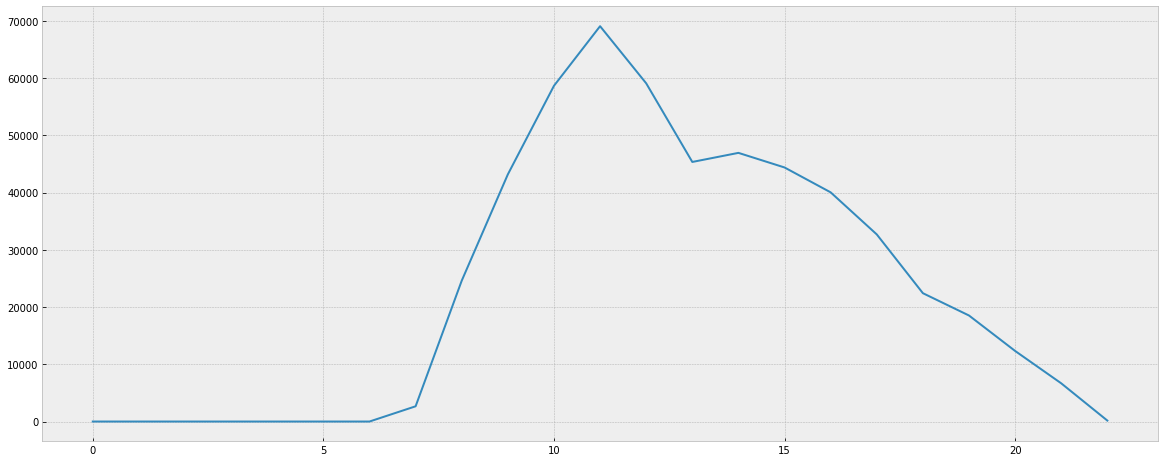

In [170]:
plt.figure(figsize = (20,8))
plt.plot(cluster4.groupby(['Hour']).sum()['spend'])

In [171]:
cluster4['Month'].value_counts()

5    10221
3    10084
6     9679
4     9675
7     9674
8     9448
Name: Month, dtype: int64

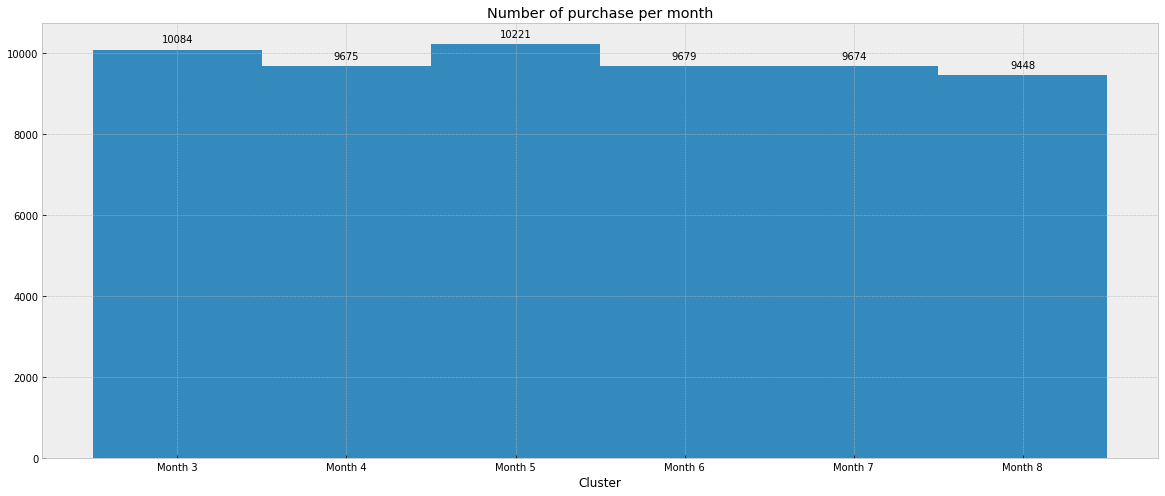

In [172]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster4['Month'], bins=6)
plt.xlabel("Cluster")
plt.title("Number of purchase per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(3, 10)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

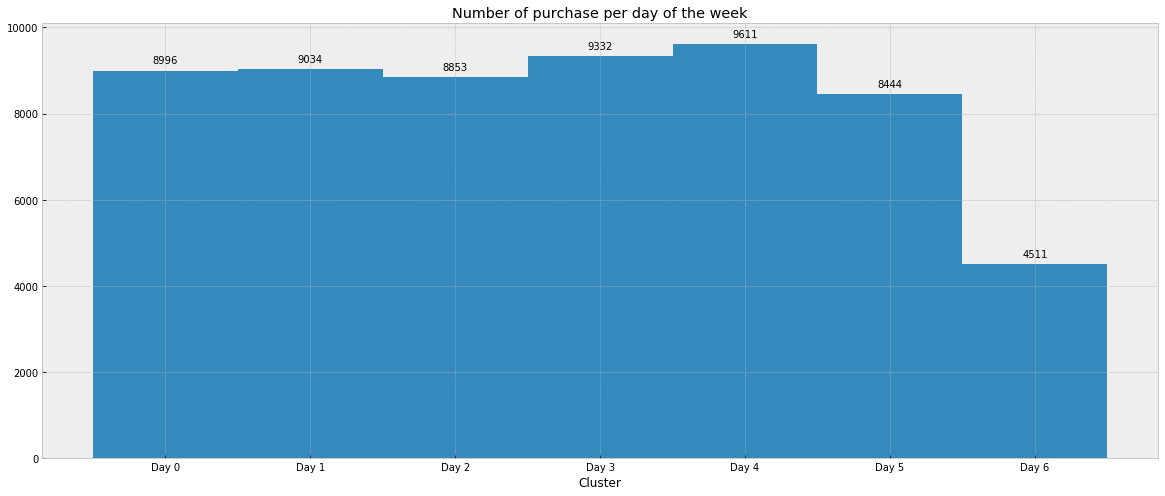

In [173]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster4['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of purchase per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

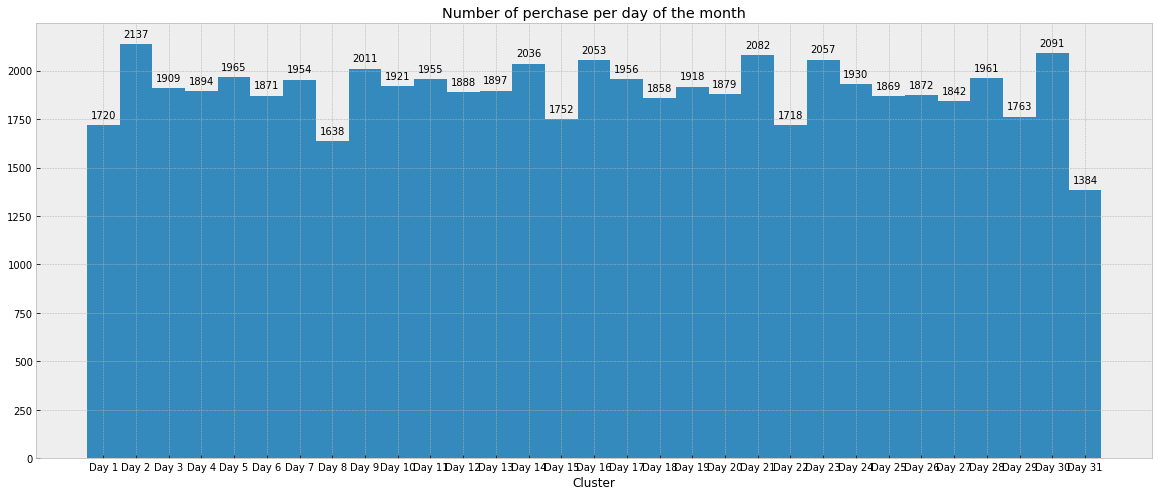

In [174]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster4['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of perchase per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

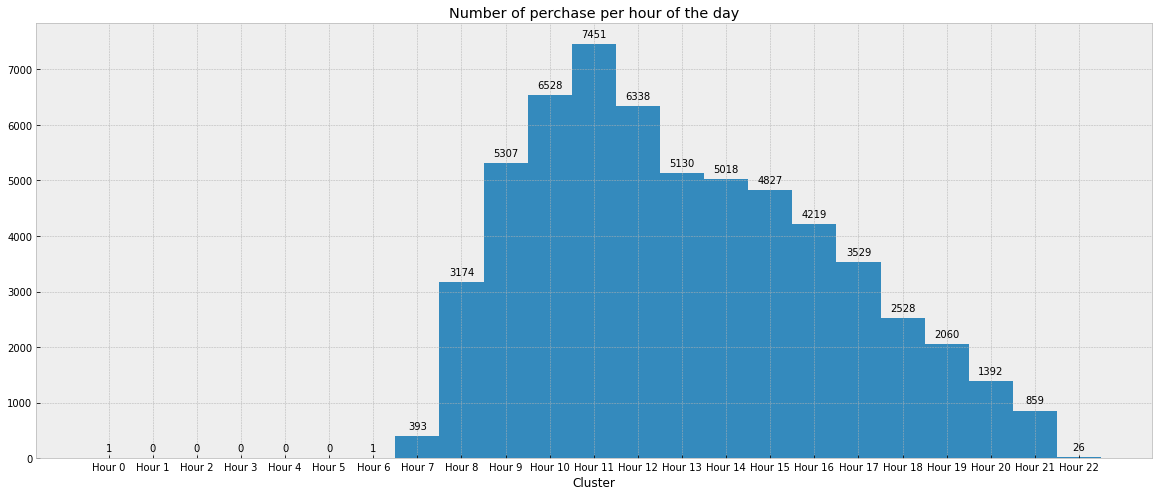

In [175]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster4['Hour'], bins=np.arange(0,24,1))
plt.xlabel("Cluster")
plt.title("Number of perchase per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in range(0, 24)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [176]:
print("Key figures:")
print('Min Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==4].mean()[0]))
print('Max Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==4].mean()[1]))
print('Mean Basket Spend:'+"%.2f" % (df_final[df_final['cluster']==4].mean()[2]))
print('Average_spend:'+"%.2f" % (cluster4.groupby(by='customer_number').sum().mean()[1]))
print('Recency:'+"%.2f" % (cluster4.mean()[7]))
print('Frequency:'+"%.2f" % (cluster4.mean()[9]))

Key figures:
Min Basket Spend:1.10
Max Basket Spend:38.61
Mean Basket Spend:9.15
Average_spend:1104.20
Recency:1.70
Frequency:126.76


In [177]:
print("TOP 10 spends products :")
print(data4.groupby('category').sum()['spend'].sort_values(ascending=False)[:10])

TOP 10 spends products :
category
TOBACCO                89337.56
DRINKS                 45860.79
DAIRY                  45469.39
FRUIT_VEG              41694.77
CASHPOINT              40843.98
GROCERY_FOOD           34991.00
GROCERY_HEALTH_PETS    34557.35
CONFECTIONARY          33955.10
MEAT                   29892.12
BAKERY                 25258.46
Name: spend, dtype: float64


In [178]:
print("TOP 10 quantities products :")
print(data4.groupby('category').sum()['quantity'].sort_values(ascending=False)[:10])

TOP 10 quantities products :
category
DAIRY                   50121
CONFECTIONARY           47352
FRUIT_VEG               45958
GROCERY_FOOD            41675
GROCERY_HEALTH_PETS     32020
BAKERY                  31098
NEWSPAPERS_MAGAZINES    23878
TOBACCO                 21086
SOFT_DRINKS             18861
PREPARED_MEALS          15902
Name: quantity, dtype: int32


In [179]:
cluster4_RFMScore['RFMScore'].value_counts()

111    153
112     93
211     83
212     36
113     34
311     17
411     12
213     11
412      9
312      8
114      6
214      5
413      5
313      3
414      1
314      1
Name: RFMScore, dtype: int64